In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import os
import pickle
import cv2
import pandas as pd
from tqdm import tqdm
import datetime as dt
import statistics as stat
from joblib import load, dump
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.utils import np_utils
from tensorflow.keras.models import load_model
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Using TensorFlow backend.


Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4524830175905584752
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4172745434971977285
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
gnd_truth = pd.read_csv("data\SkinDiseaseDataset\ISIC_2019_Training_GroundTruth.csv")
#aug_df = pd.read_csv("data/augmentImageNameLabels.csv")
gnd_truth.head()

IMG_NAMES = gnd_truth['image']
TRAIN_IMG_RT_PATH = 'data/ISIC_2019_Training_Input/'
TEST_IMG_RT_PATH = 'data/ISIC_2019_Test_Input'
### No Examples of UNK so drop it
labels = np.array(gnd_truth.drop(columns = ["image", "UNK"]))

In [3]:
os.listdir("models")

['checkpoints',
 'model.h5',
 'model.json',
 'model1.h5',
 'model1.json',
 'model_fashion_90acc1.h5',
 'model_fashion_90acc1.json',
 'model_fine_labels.h5',
 'model_fine_labels.json',
 'resnet_model1_cifar10.h5',
 'resnet_model1_cifar10.json',
 'skin_disease_resnet_No_AUG_88acc.h5',
 'skin_disease_resnet_No_AUG_88acc.json']

In [4]:
from tensorflow.keras.models import model_from_json

In [5]:
with open('models/resnet_model1_cifar10.json', 'r') as jfile:
    loaded_from_json = jfile.read()
cirfar_resnet_model = model_from_json(loaded_from_json)
cirfar_resnet_model.load_weights("models/resnet_model1_cifar10.h5")

In [6]:
cirfar_resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) multiple                  0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 multiple                  0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 multiple                  0         
_________________________________________________________________
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  524288    
_________________________________________________________________
dense (Dense)                multiple                  1

In [7]:
###To be ran Only one everytime notebook restarts
for i in range(3):
    cirfar_resnet_model._layers.pop(0)
for i in range(6):
    cirfar_resnet_model._layers.pop()

In [8]:
from tensorflow.keras.layers import Input
new_input = Input((256,256,3))
new_output = cirfar_resnet_model(new_input)
extractor = tf.keras.Model(new_input, new_output)

In [9]:
def loadPreprocess():
    ### Load In Data
    (trainX, trainY), (testX, testY) = tf.keras.datasets.cifar10.load_data()
    trainY = tf.keras.utils.to_categorical(trainY)
    testY = tf.keras.utils.to_categorical(testY)
    return [trainX/255, trainY, testX/255, testY]


def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]

trainX, trainY, testX, testY = loadPreprocess()


In [10]:
print("Extracting imgages from cirfar10 Dataset")
train_feat_list = []
for i in tqdm(range(len(trainX))):
    img = trainX[i]
    img = cv2.resize(img, (256,256))
    train_feat_list.append(extractor.predict(np.expand_dims(img,axis = 0)))

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [43:37<00:00, 19.10it/s]


In [ ]:
print("Extracting imgages from SkinDisease Dataset")
skin_train_feat_list = []
for i in tqdm(range(len(trainX))):
    img = plt.imread(TRAIN_IMG_RT_PATH + IMG_NAMES[i] + '.jpg')
    img = cv2.resize(img, (256,256))
    skin_train_feat_list.append(extractor.predict(np.expand_dims(img,axis = 0)))

In [16]:
from sklearn.cluster import KMeans
k = KMeans(10)
train_feat = np.vstack(train_feat_list)

In [18]:
k.fit(train_feat)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [21]:
from sklearn.metrics import accuracy_score
kpred = k.predict(train_feat)
acc = accuracy_score(np.argmax(trainY, axis = 1 ), kpred)

In [22]:
acc

0.01138

In [25]:
k.cluster_centers_.shape

(10, 128)

In [31]:
def plot_class_pdf(vals, idx):
    font = {'family' : 'sans',
            'weight' : 'bold',
            'size'   : 30}
    matplotlib.rc('font', **font)
    print("Mean: {}".format(stat.mean(vals)))
    print("Variance: {}".format(np.var(vals)))
    print("Standard Deviation: {}".format(np.std(vals)))
    plt.figure( figsize = (40, 30), facecolor = 'gray')
    plt.hist(vals, color = 'blue', edgecolor = 'black',
             bins = int(180/5))
    # Add labels
    classes =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship',
                'truck']
    plt.title('Histogram of cluster distance of each Prediction for {}'.format(classes[idx]))
    plt.xlabel('Cluster Distance')
    plt.ylabel('# of Predictions')
    #plt.set_facecolor('gray')
    plt.show()

In [32]:
f = train_feat

Mean: 76.59791564941406
Variance: 141.3870849609375
Standard Deviation: 11.890629768371582


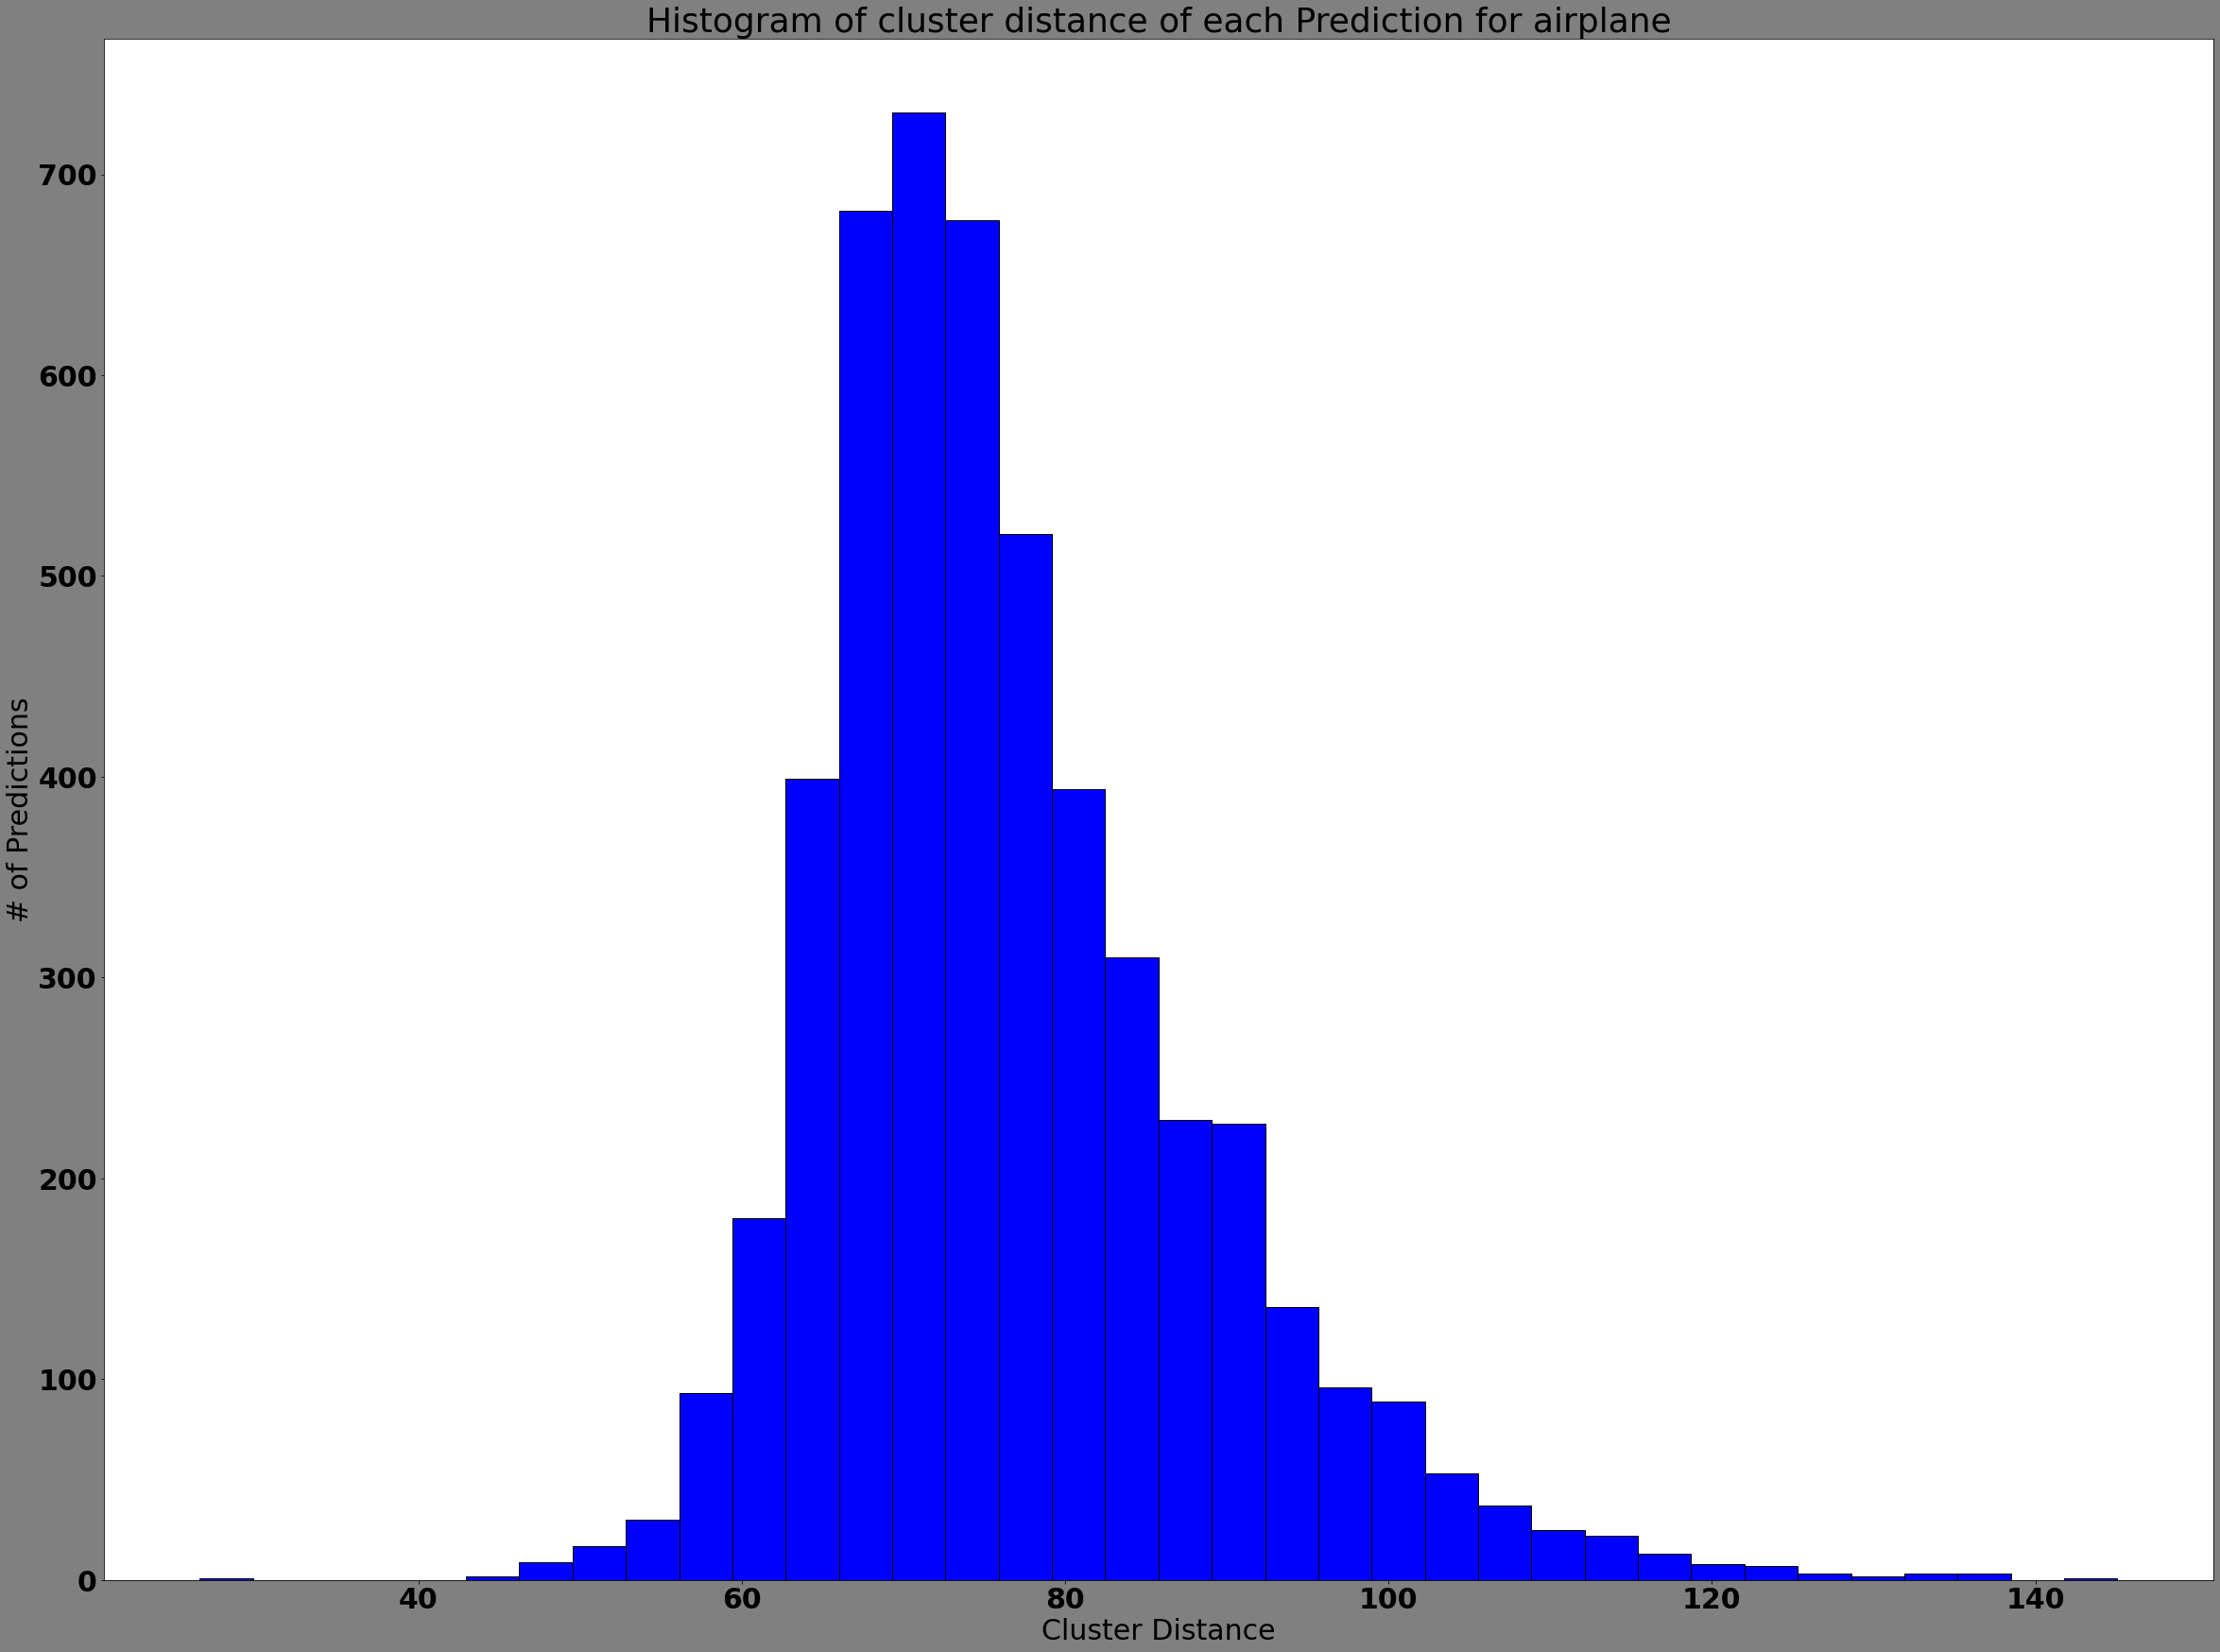

In [33]:
idx = 0

c = returnClassIndex(trainY,idx)
vals = k.transform(f[c])
plot_class_pdf(vals[:,idx], idx)

Mean: 60.602012634277344
Variance: 162.28652954101562
Standard Deviation: 12.73917293548584


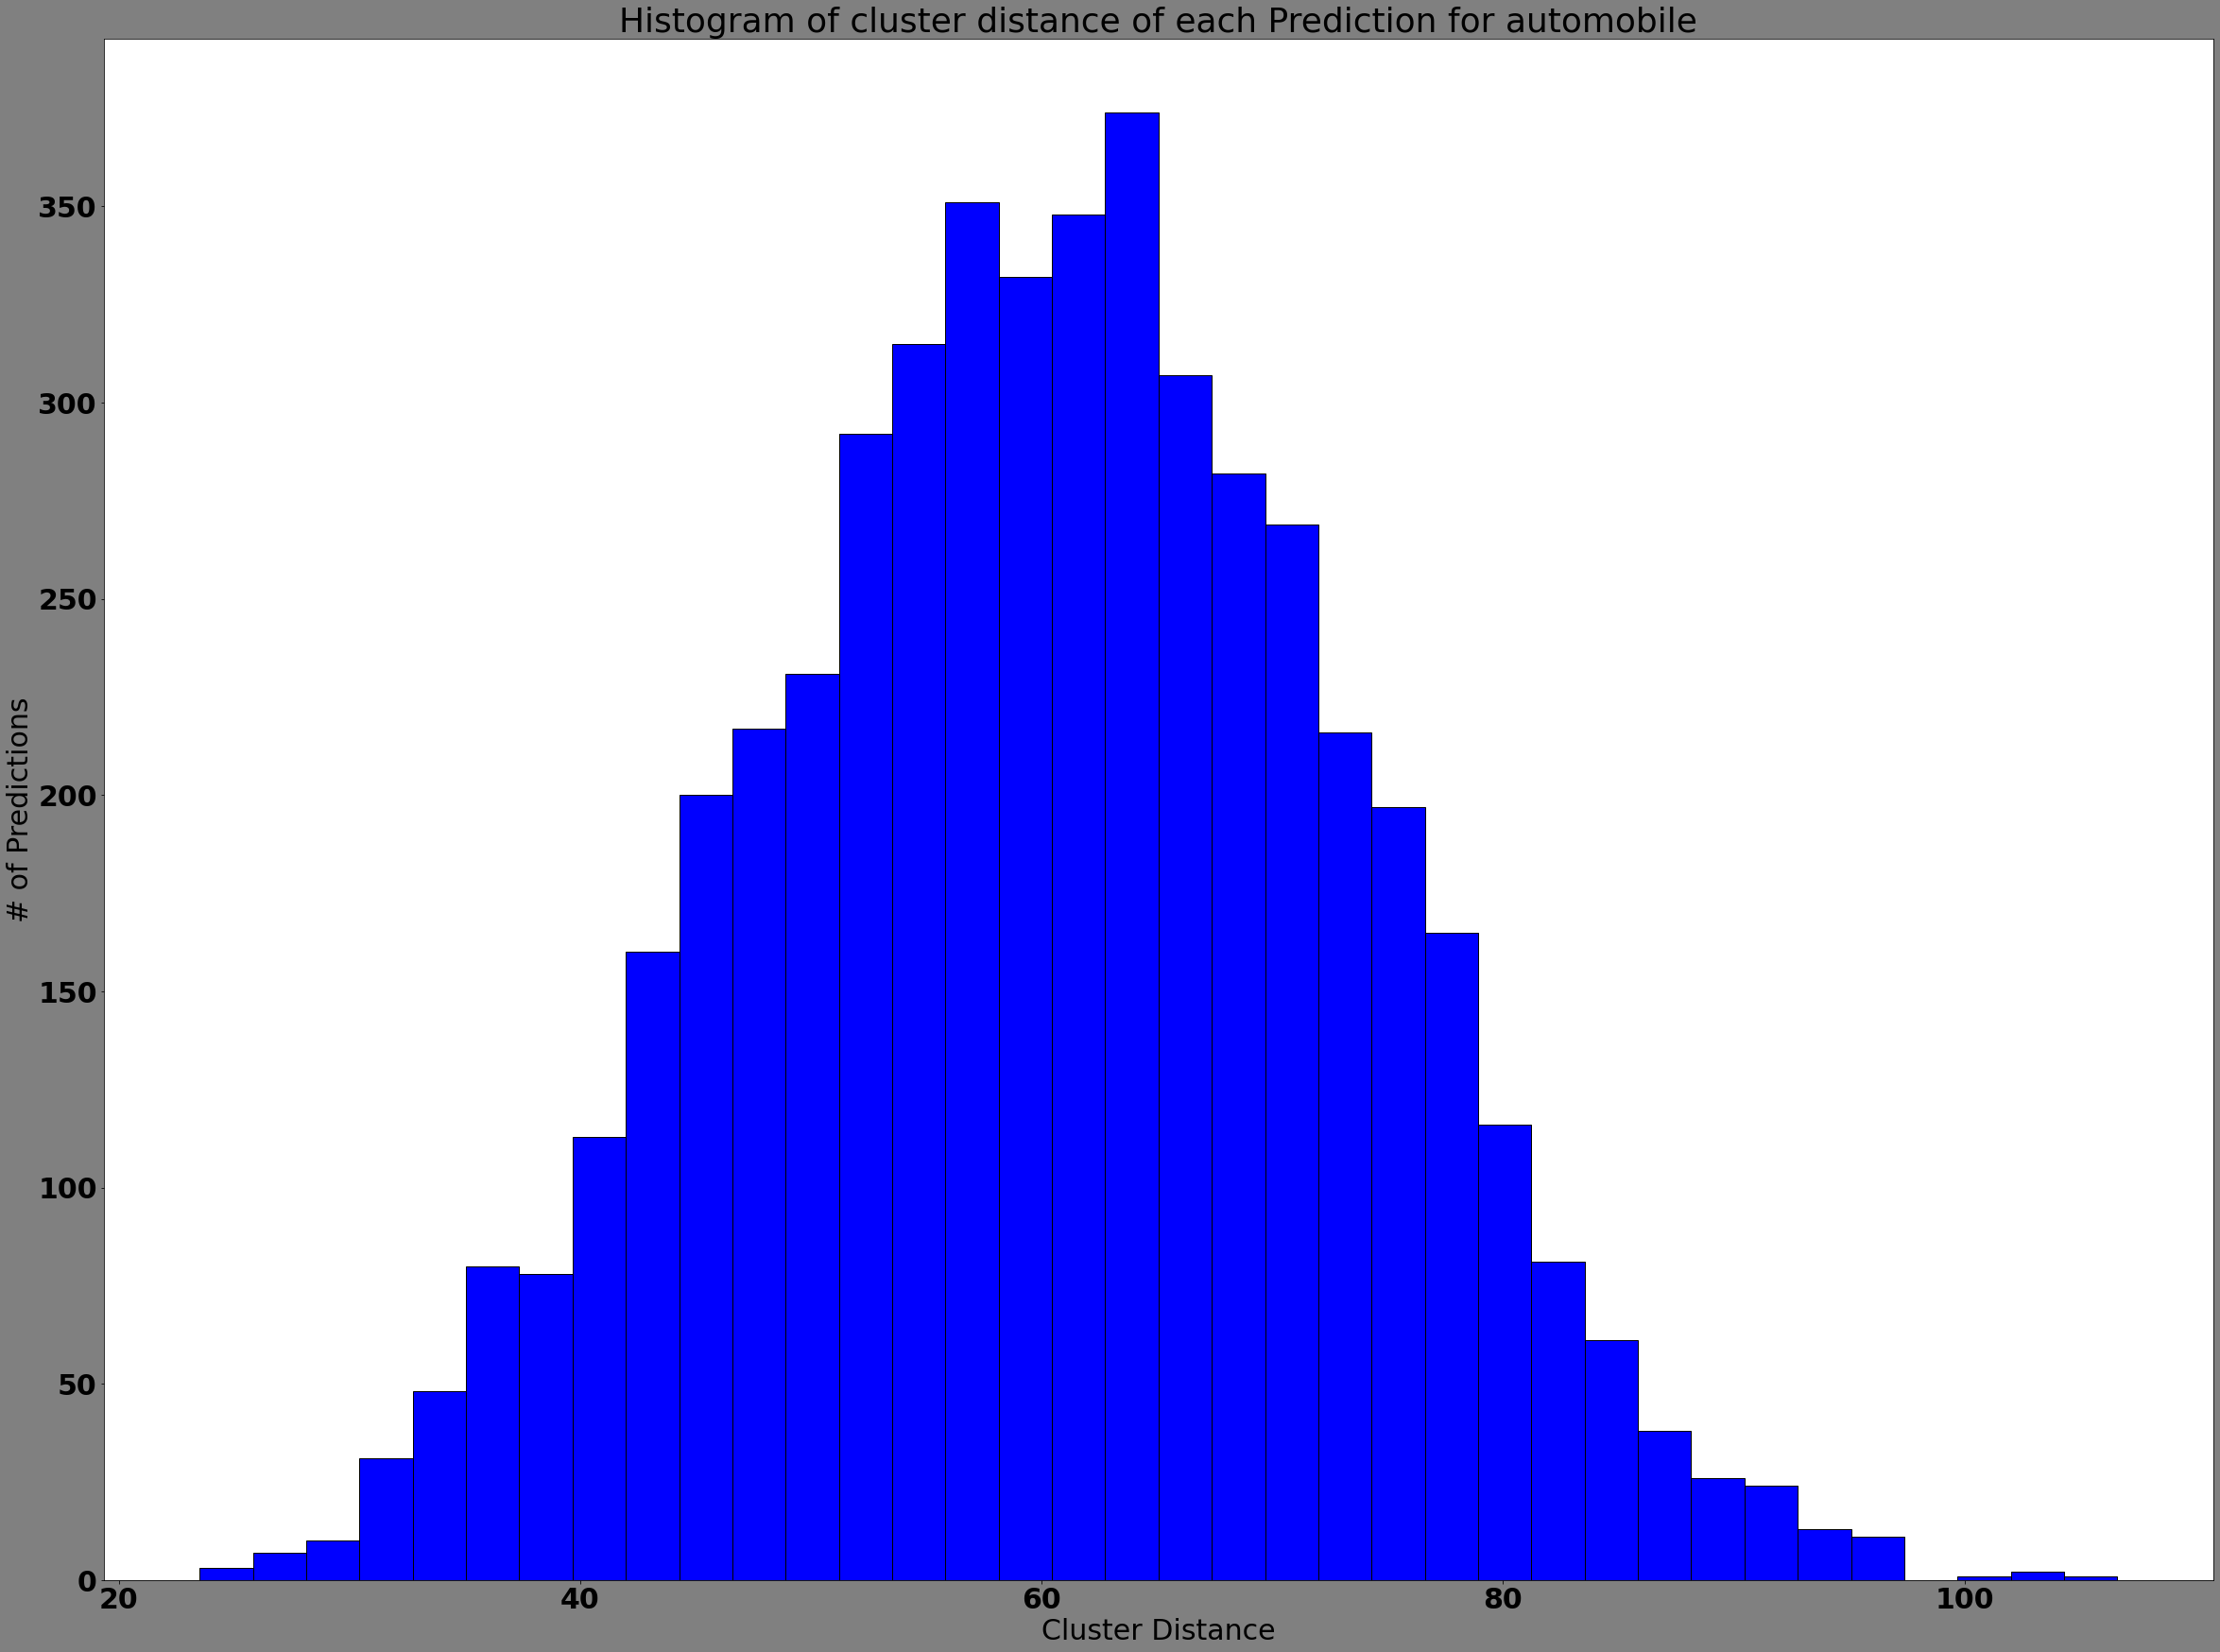

In [34]:
idx = 1

c = returnClassIndex(trainY,idx)
vals = k.transform(f[c])
plot_class_pdf(vals[:,idx], idx)

Mean: 77.78631591796875
Variance: 264.4881896972656
Standard Deviation: 16.263092041015625


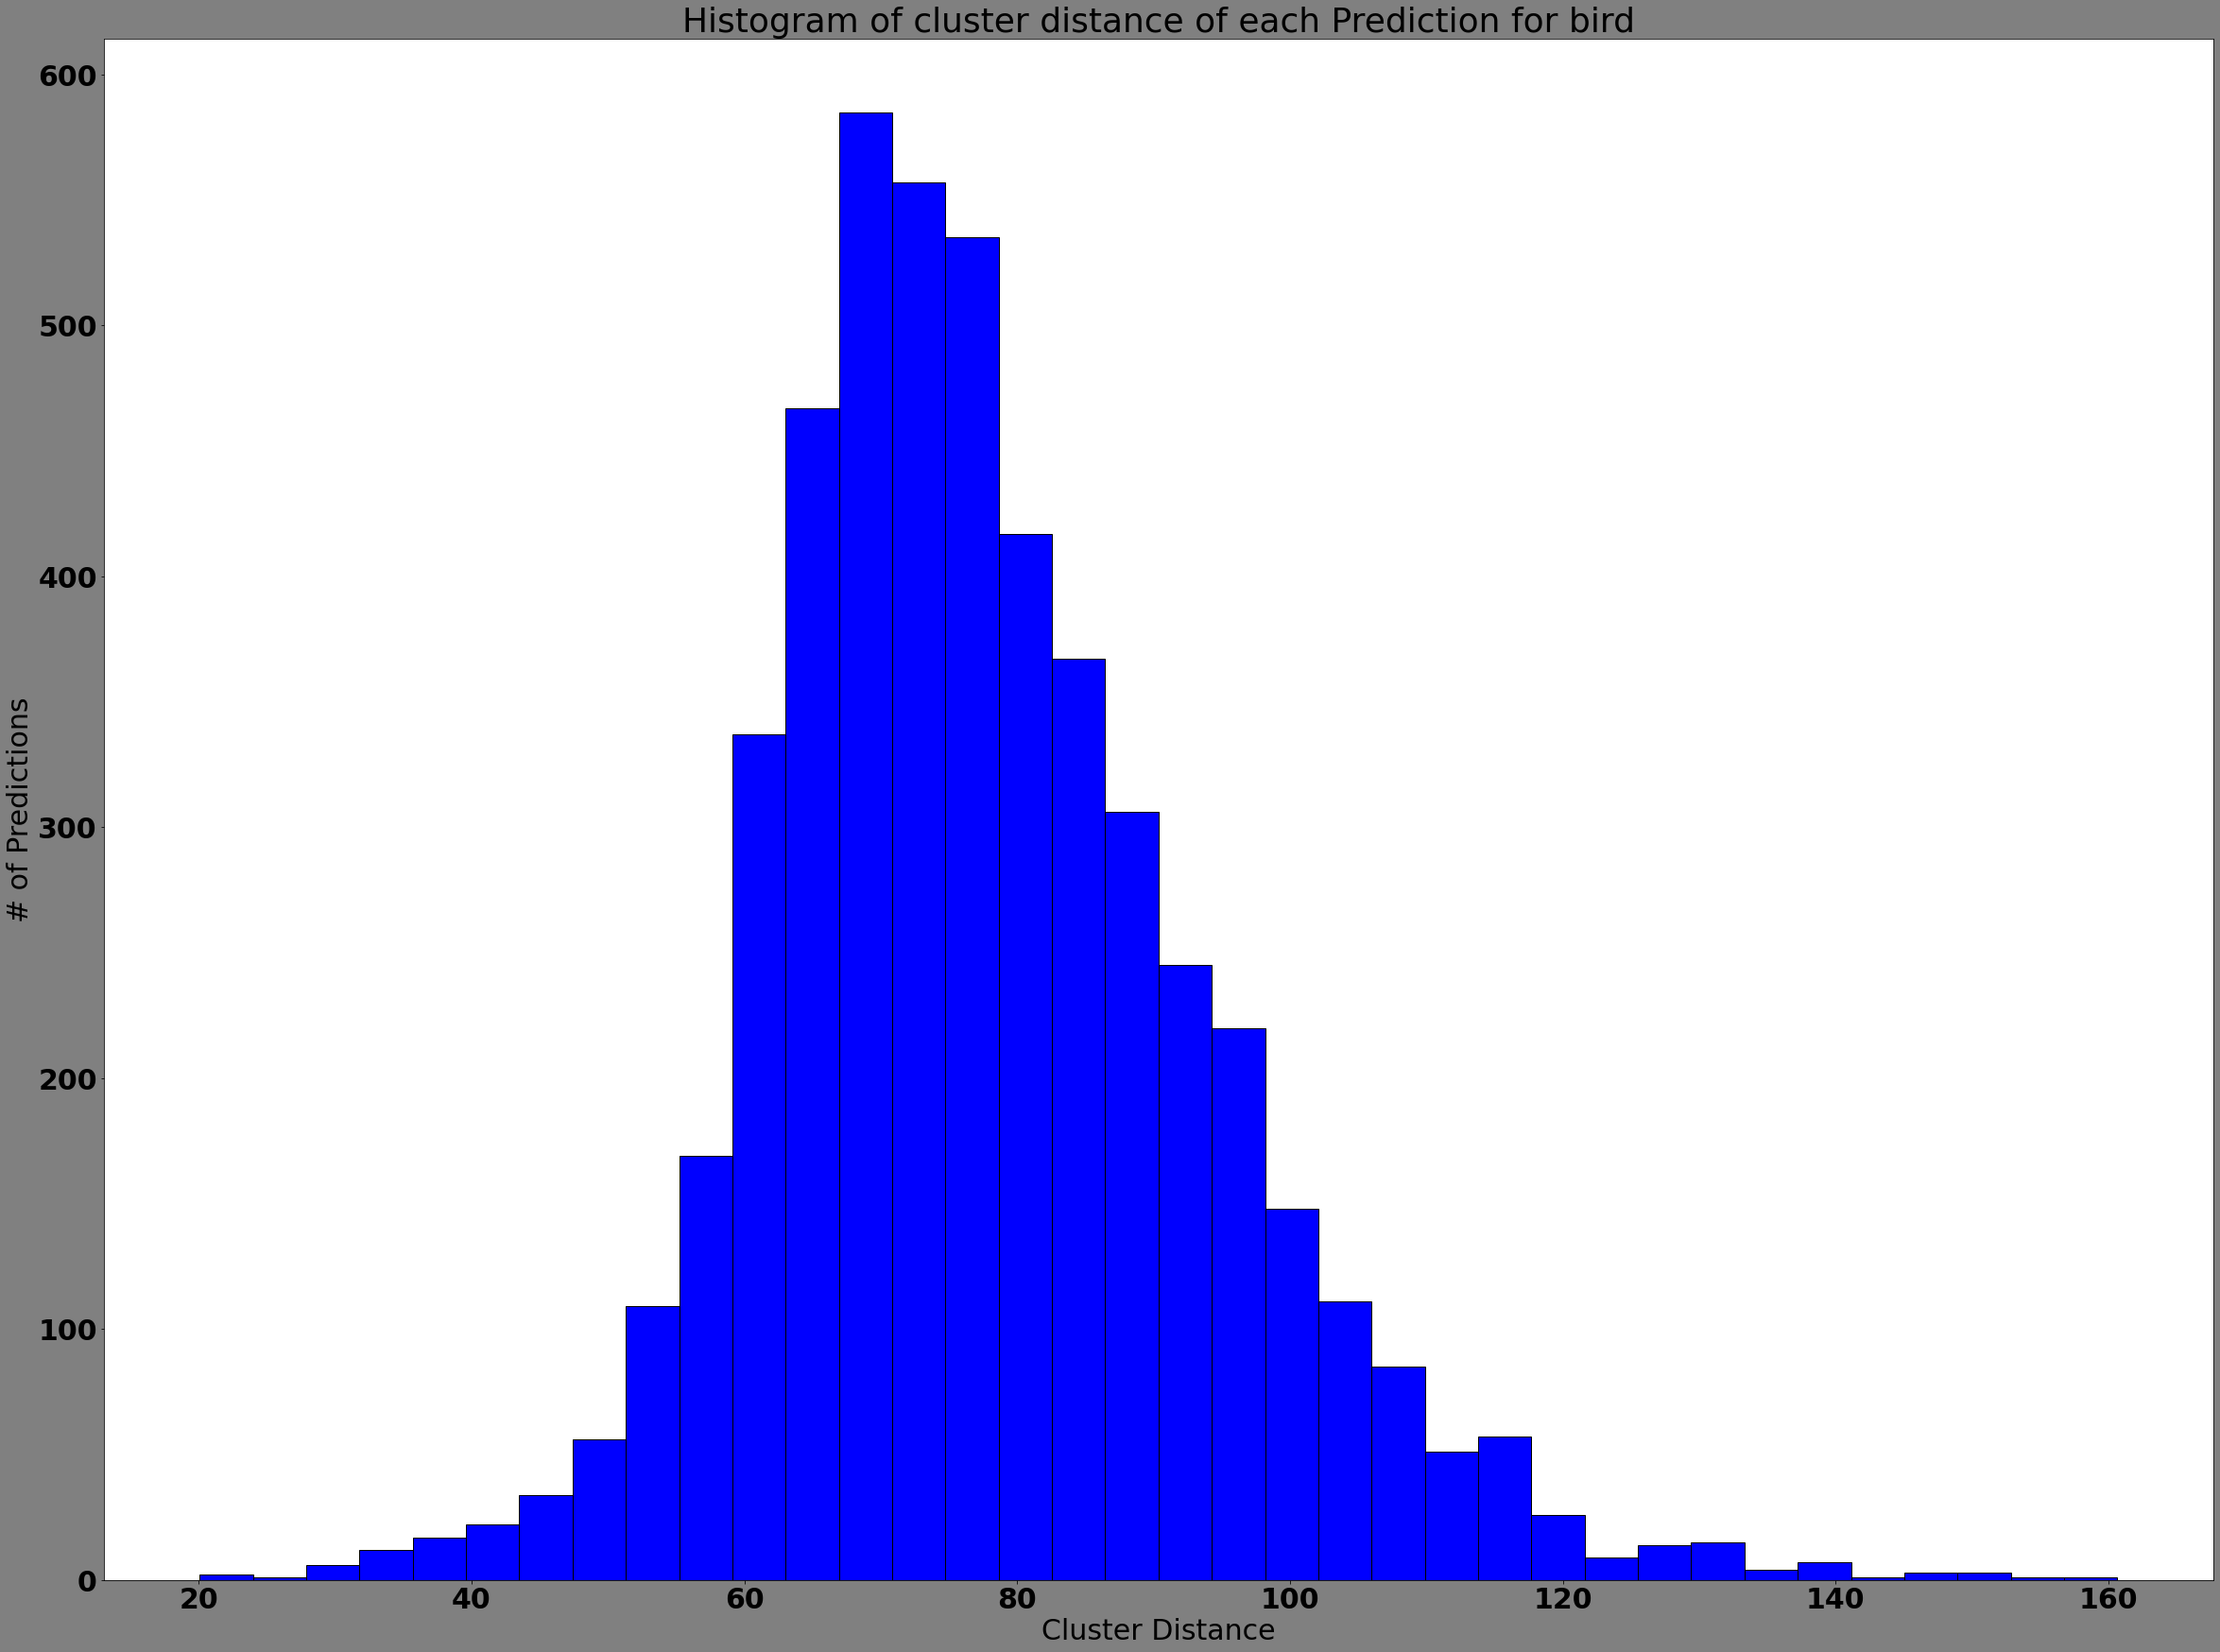

In [35]:
idx = 2

c = returnClassIndex(trainY,idx)
vals = k.transform(f[c])
plot_class_pdf(vals[:,idx], idx)

Mean: 93.42997741699219
Variance: 288.01654052734375
Standard Deviation: 16.971050262451172


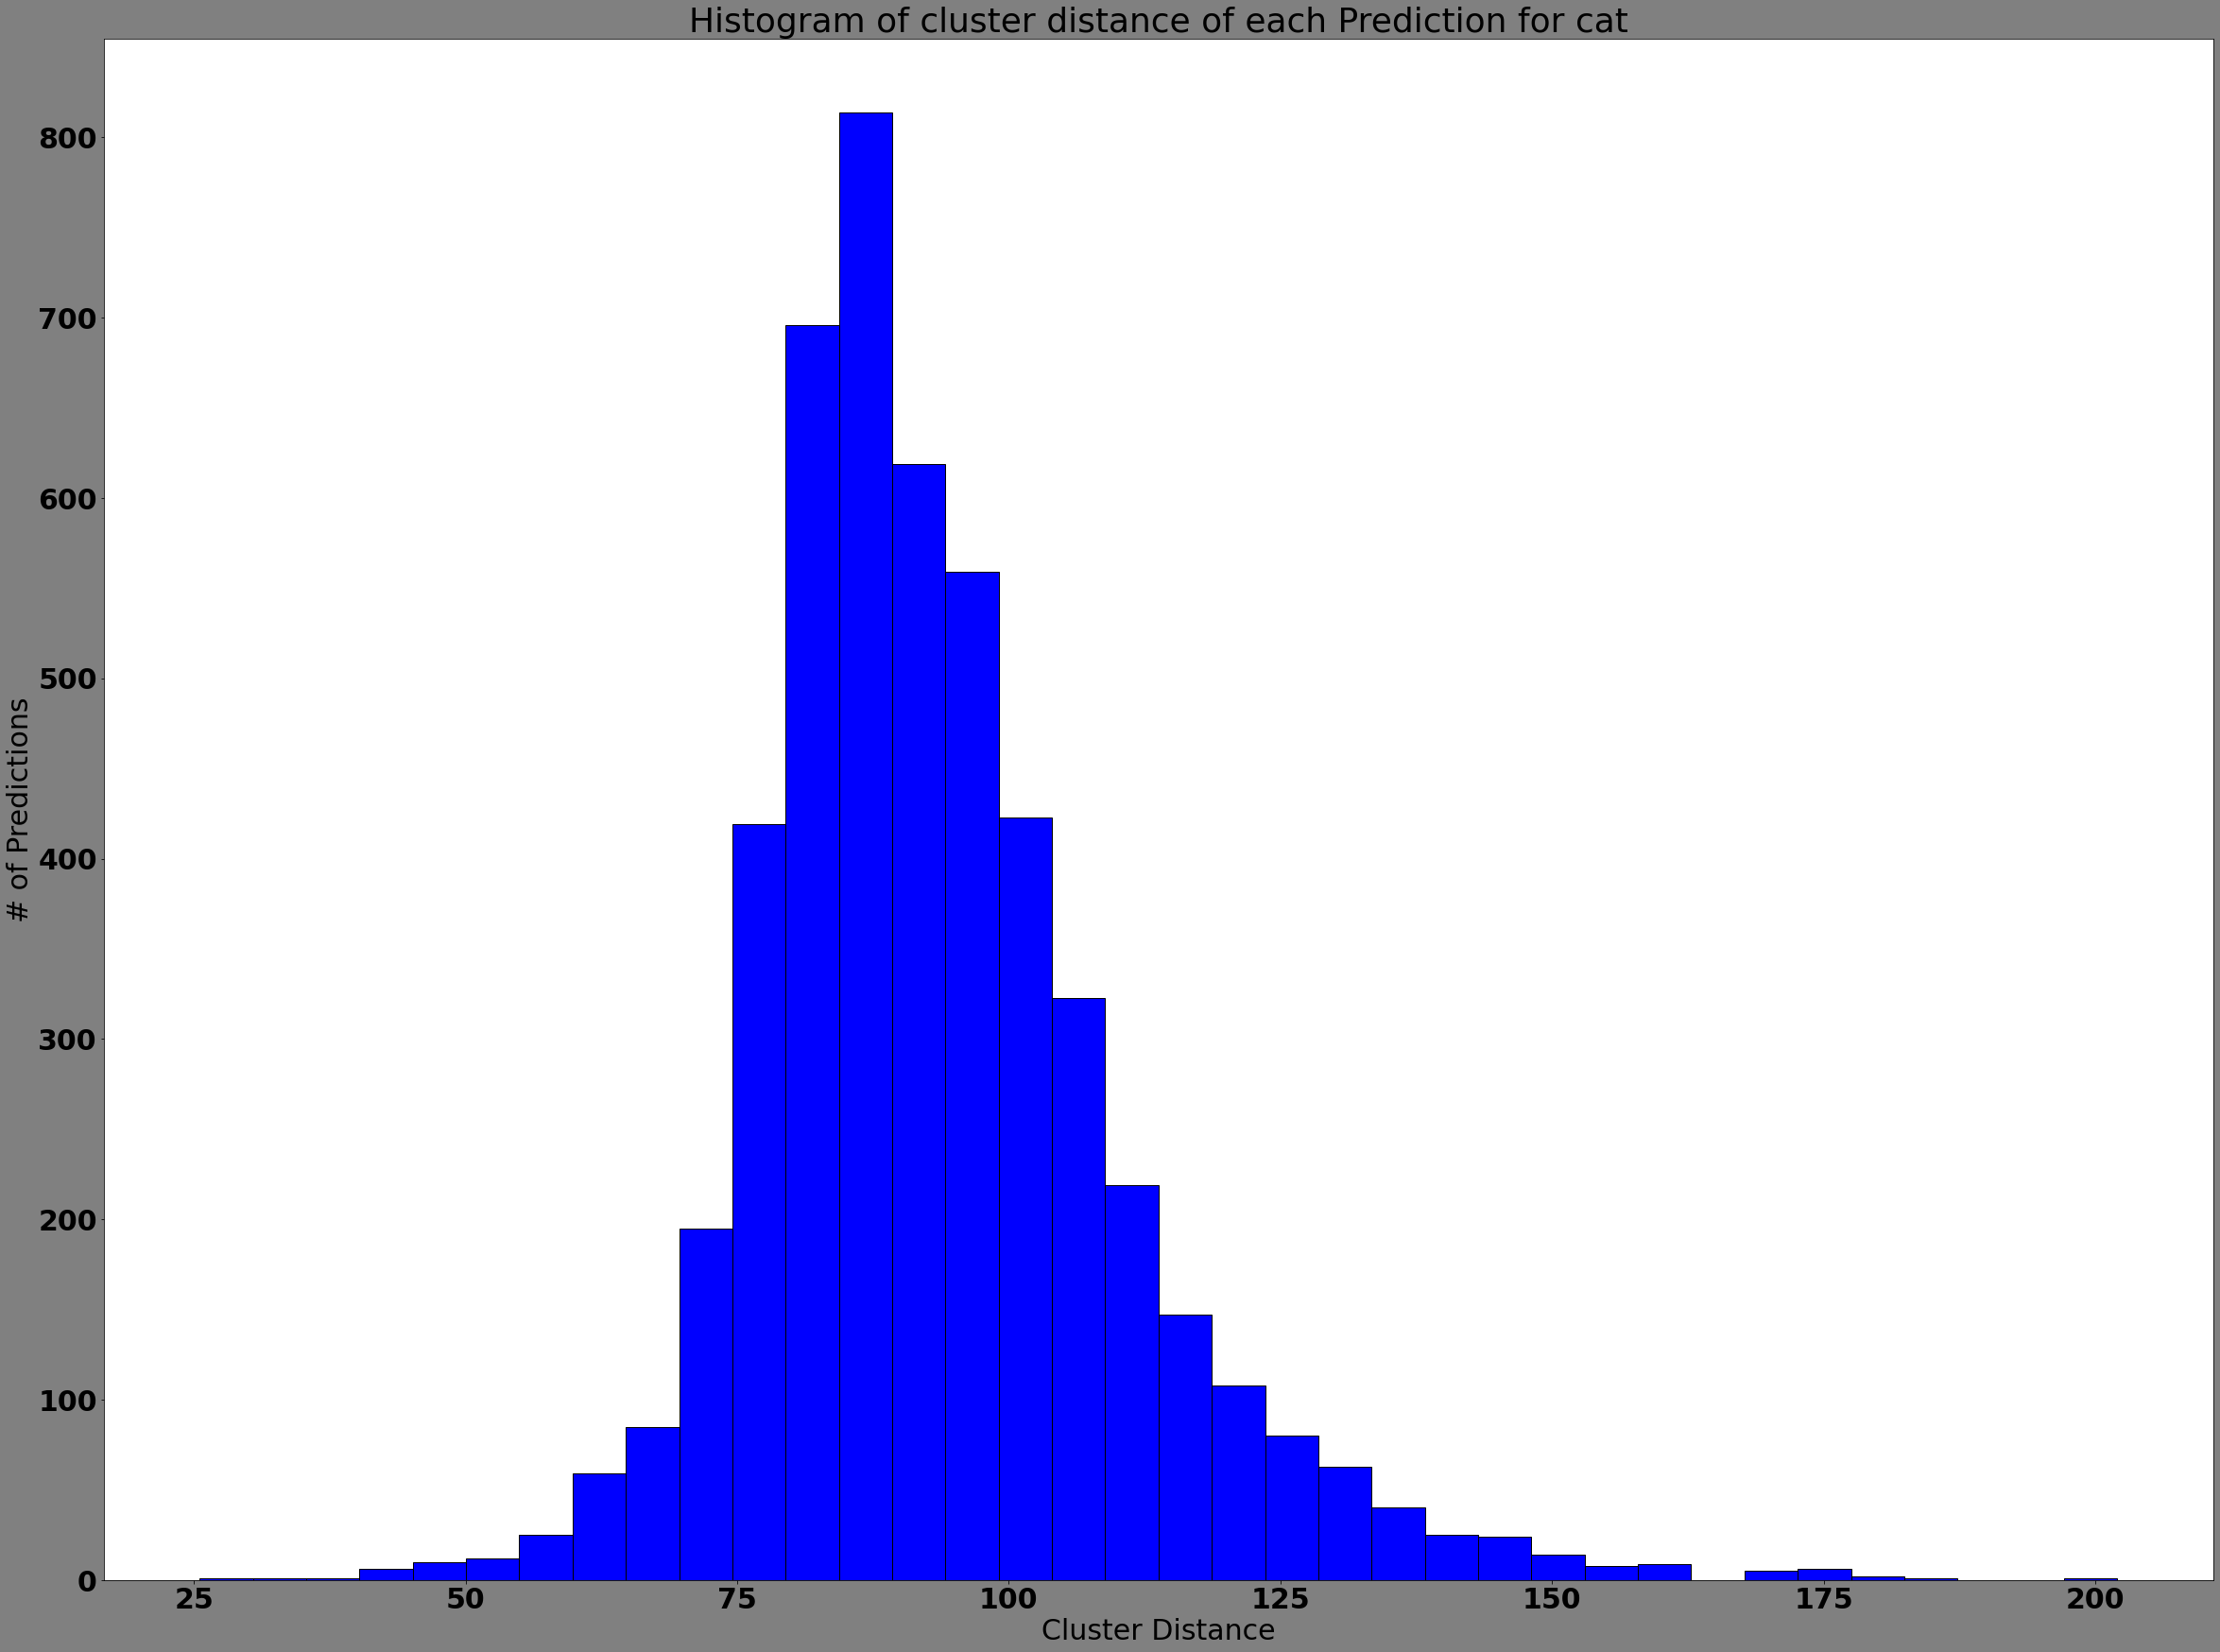

In [36]:
idx = 3

c = returnClassIndex(trainY,idx)
vals = k.transform(f[c])
plot_class_pdf(vals[:,idx], idx)

Mean: 99.8585433959961
Variance: 160.55296325683594
Standard Deviation: 12.670949935913086


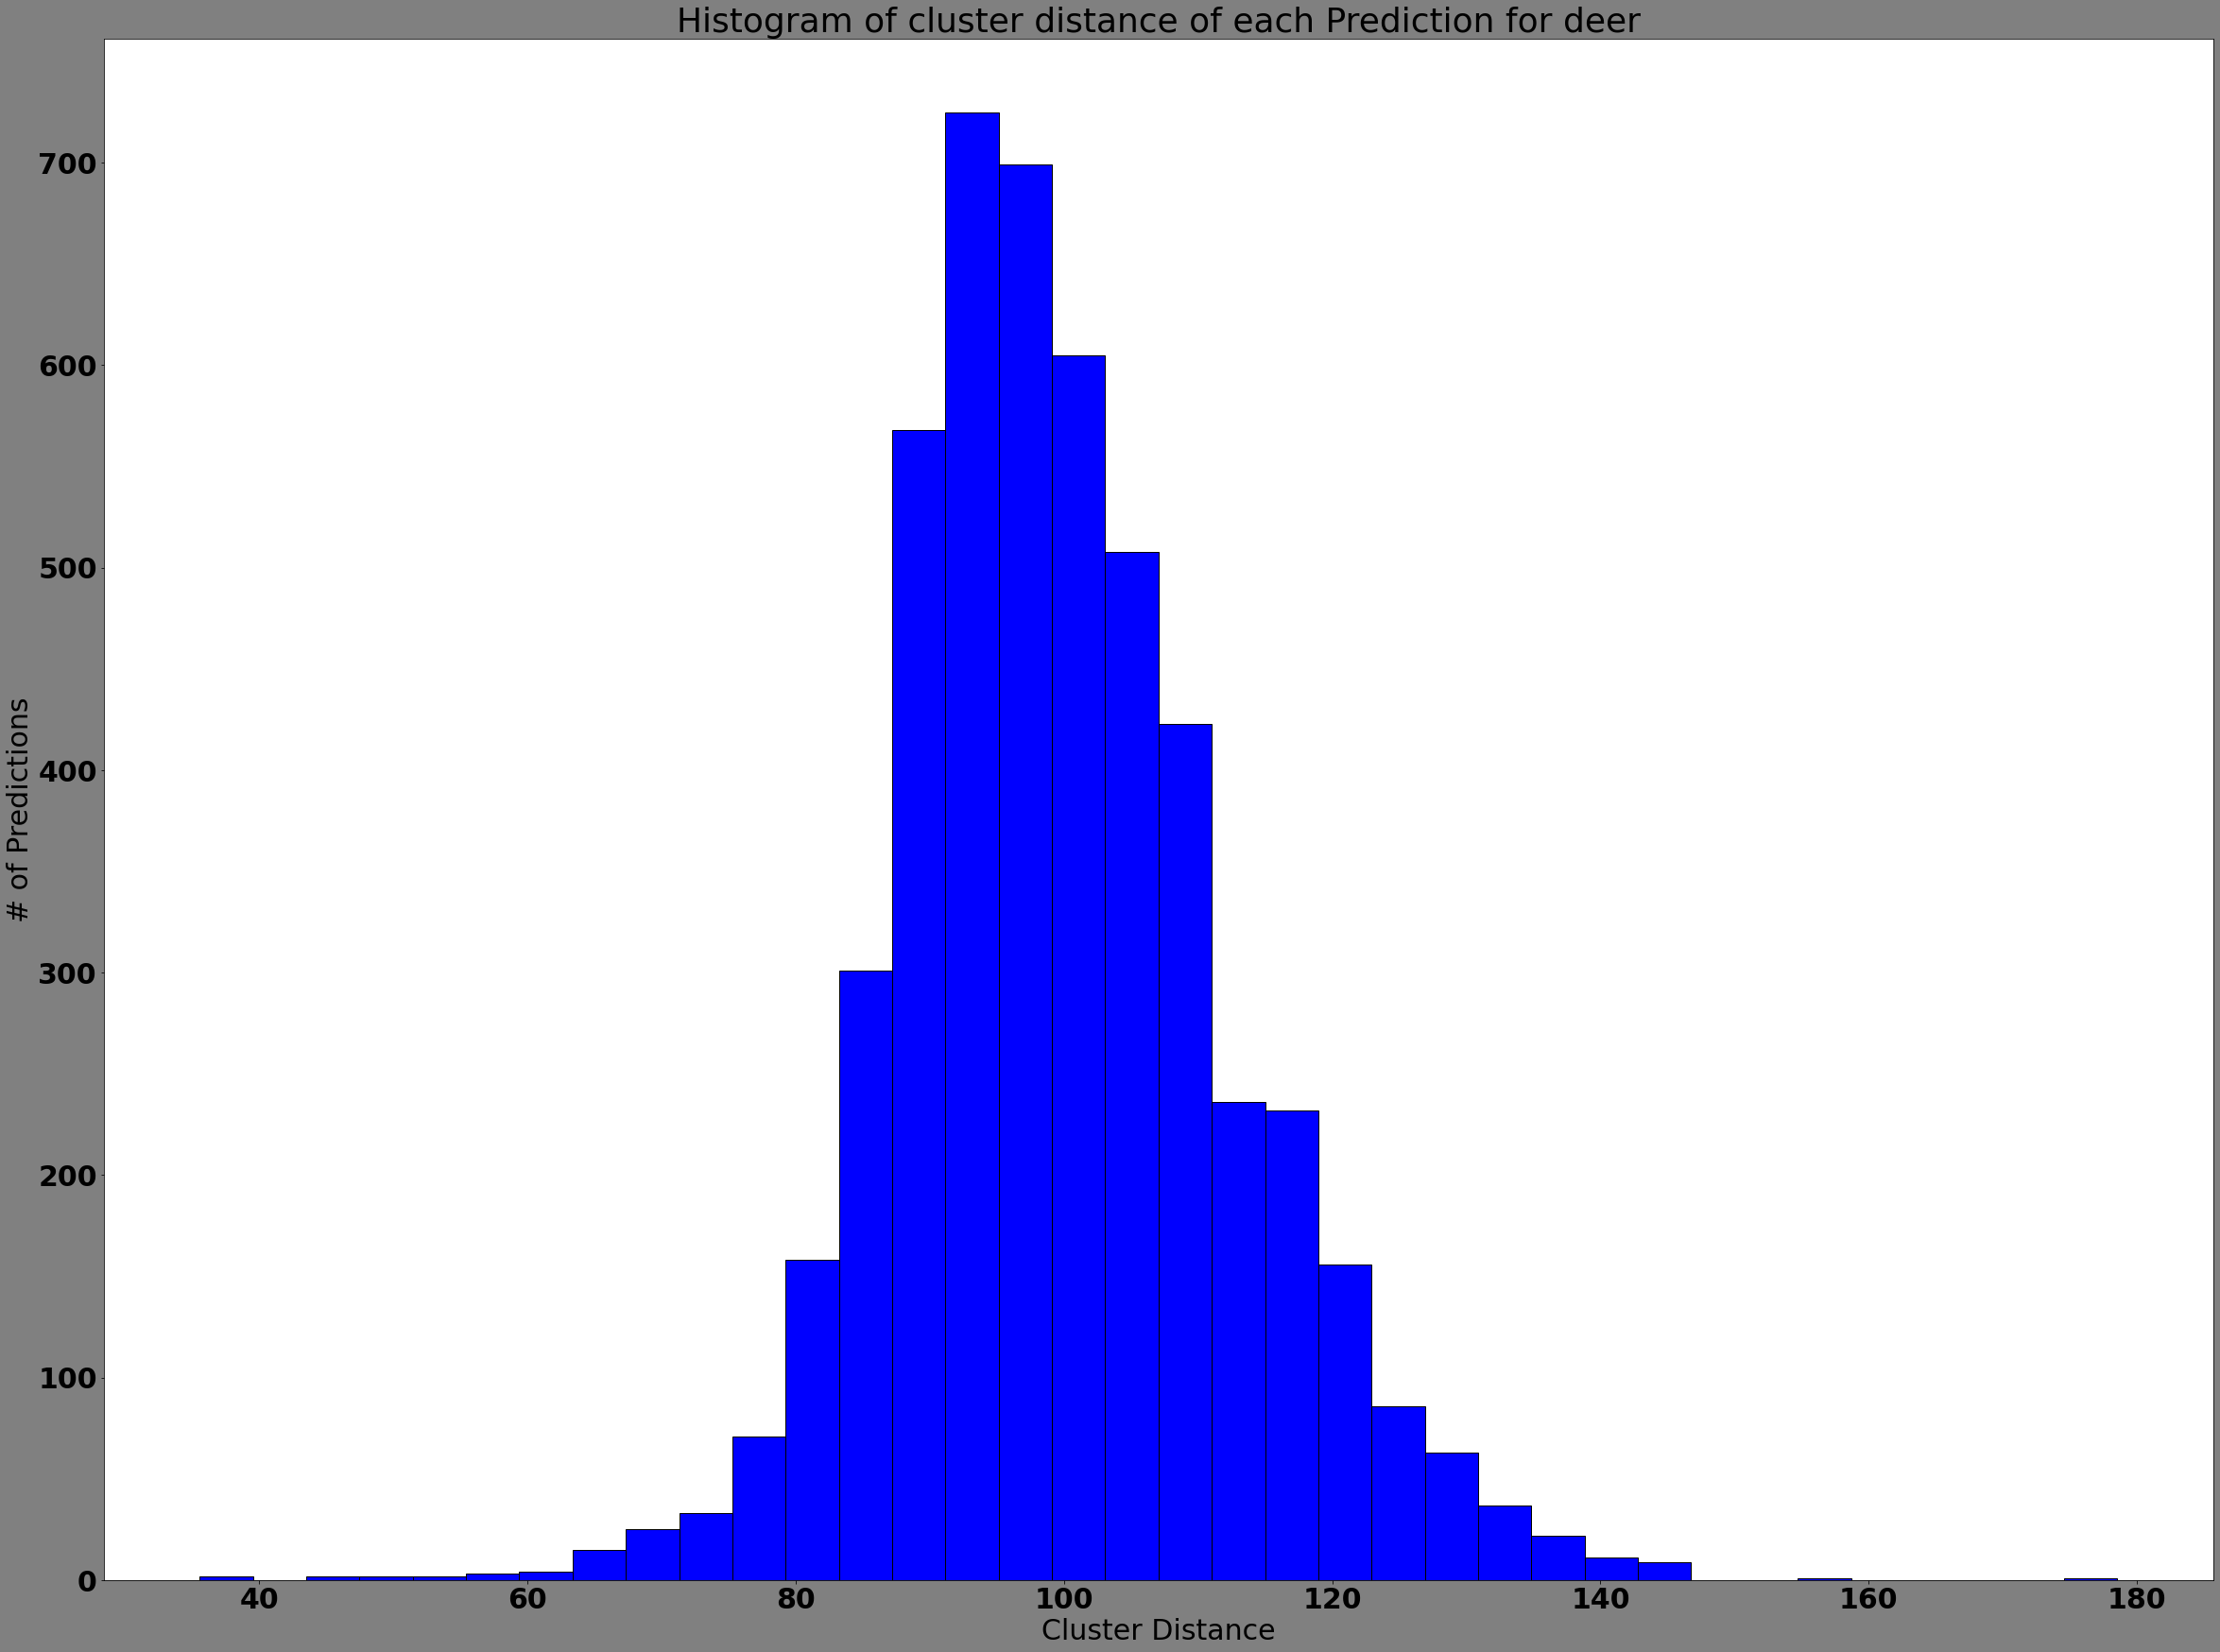

In [37]:
idx = 4

c = returnClassIndex(trainY,idx)
vals = k.transform(f[c])
plot_class_pdf(vals[:,idx], idx)

Mean: 99.801513671875
Variance: 362.2468566894531
Standard Deviation: 19.03278350830078


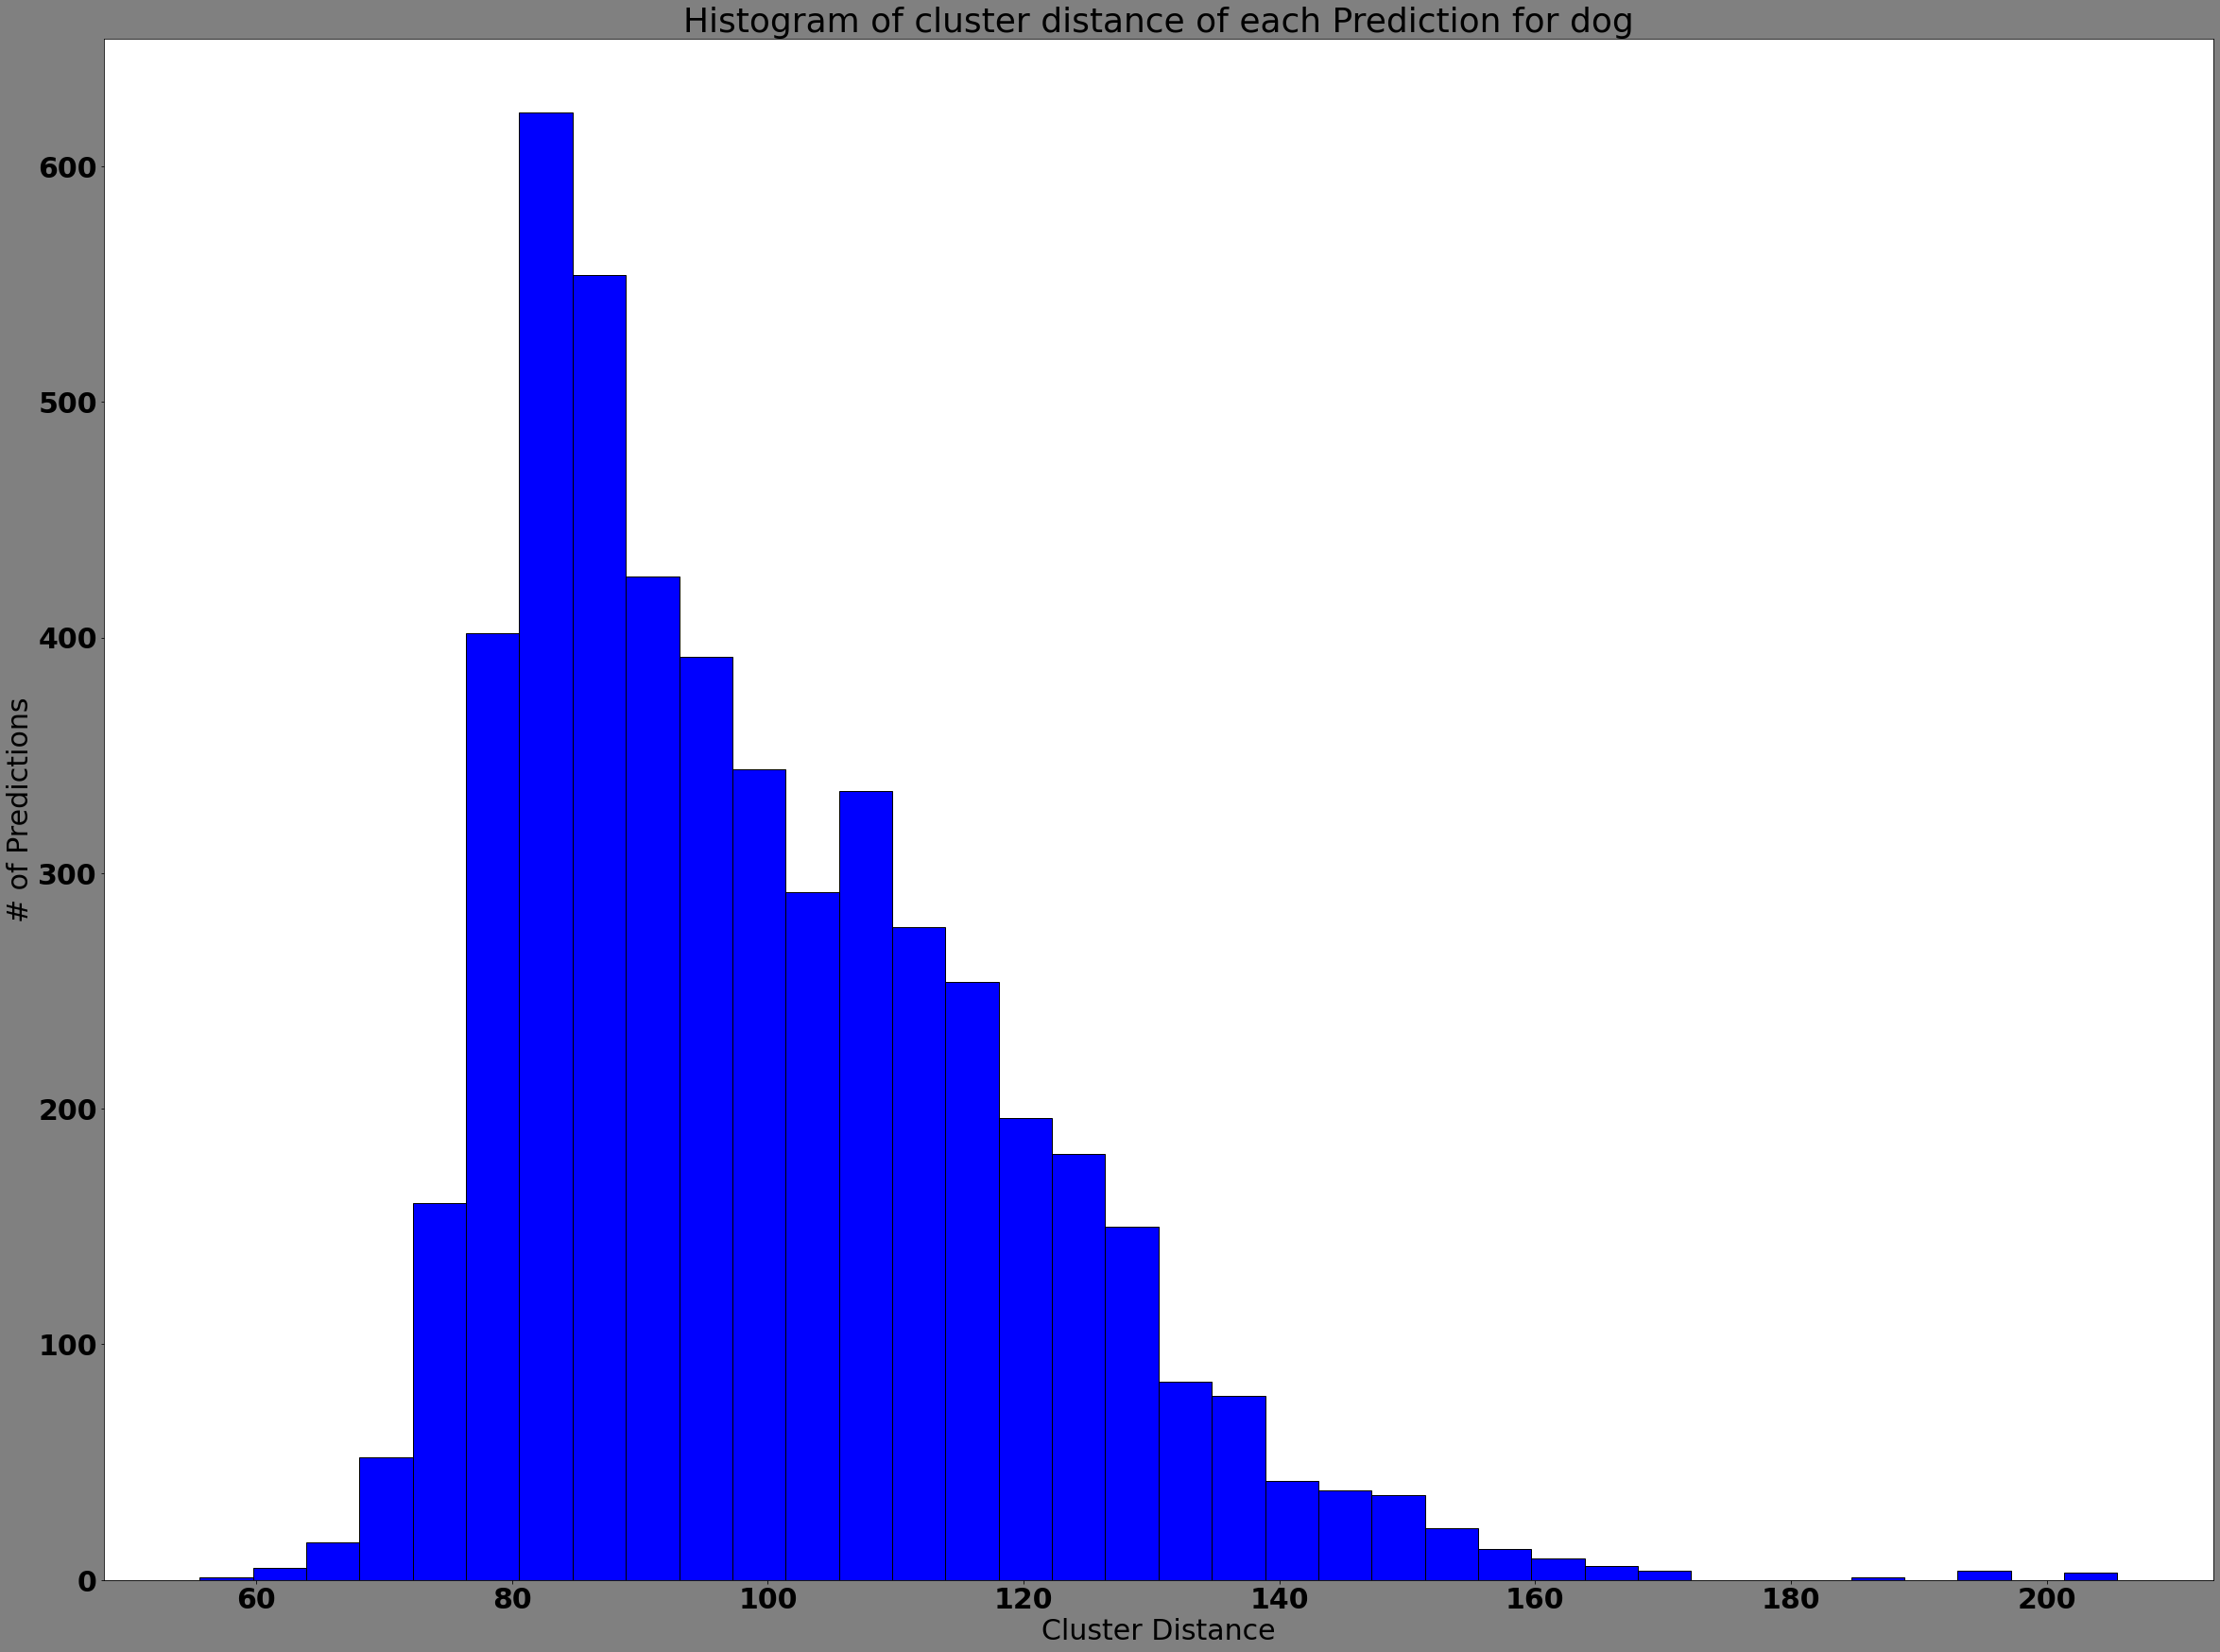

In [38]:
idx = 5

c = returnClassIndex(trainY,idx)
vals = k.transform(f[c])
plot_class_pdf(vals[:,idx], idx)

Mean: 83.9302978515625
Variance: 134.82528686523438
Standard Deviation: 11.611429214477539


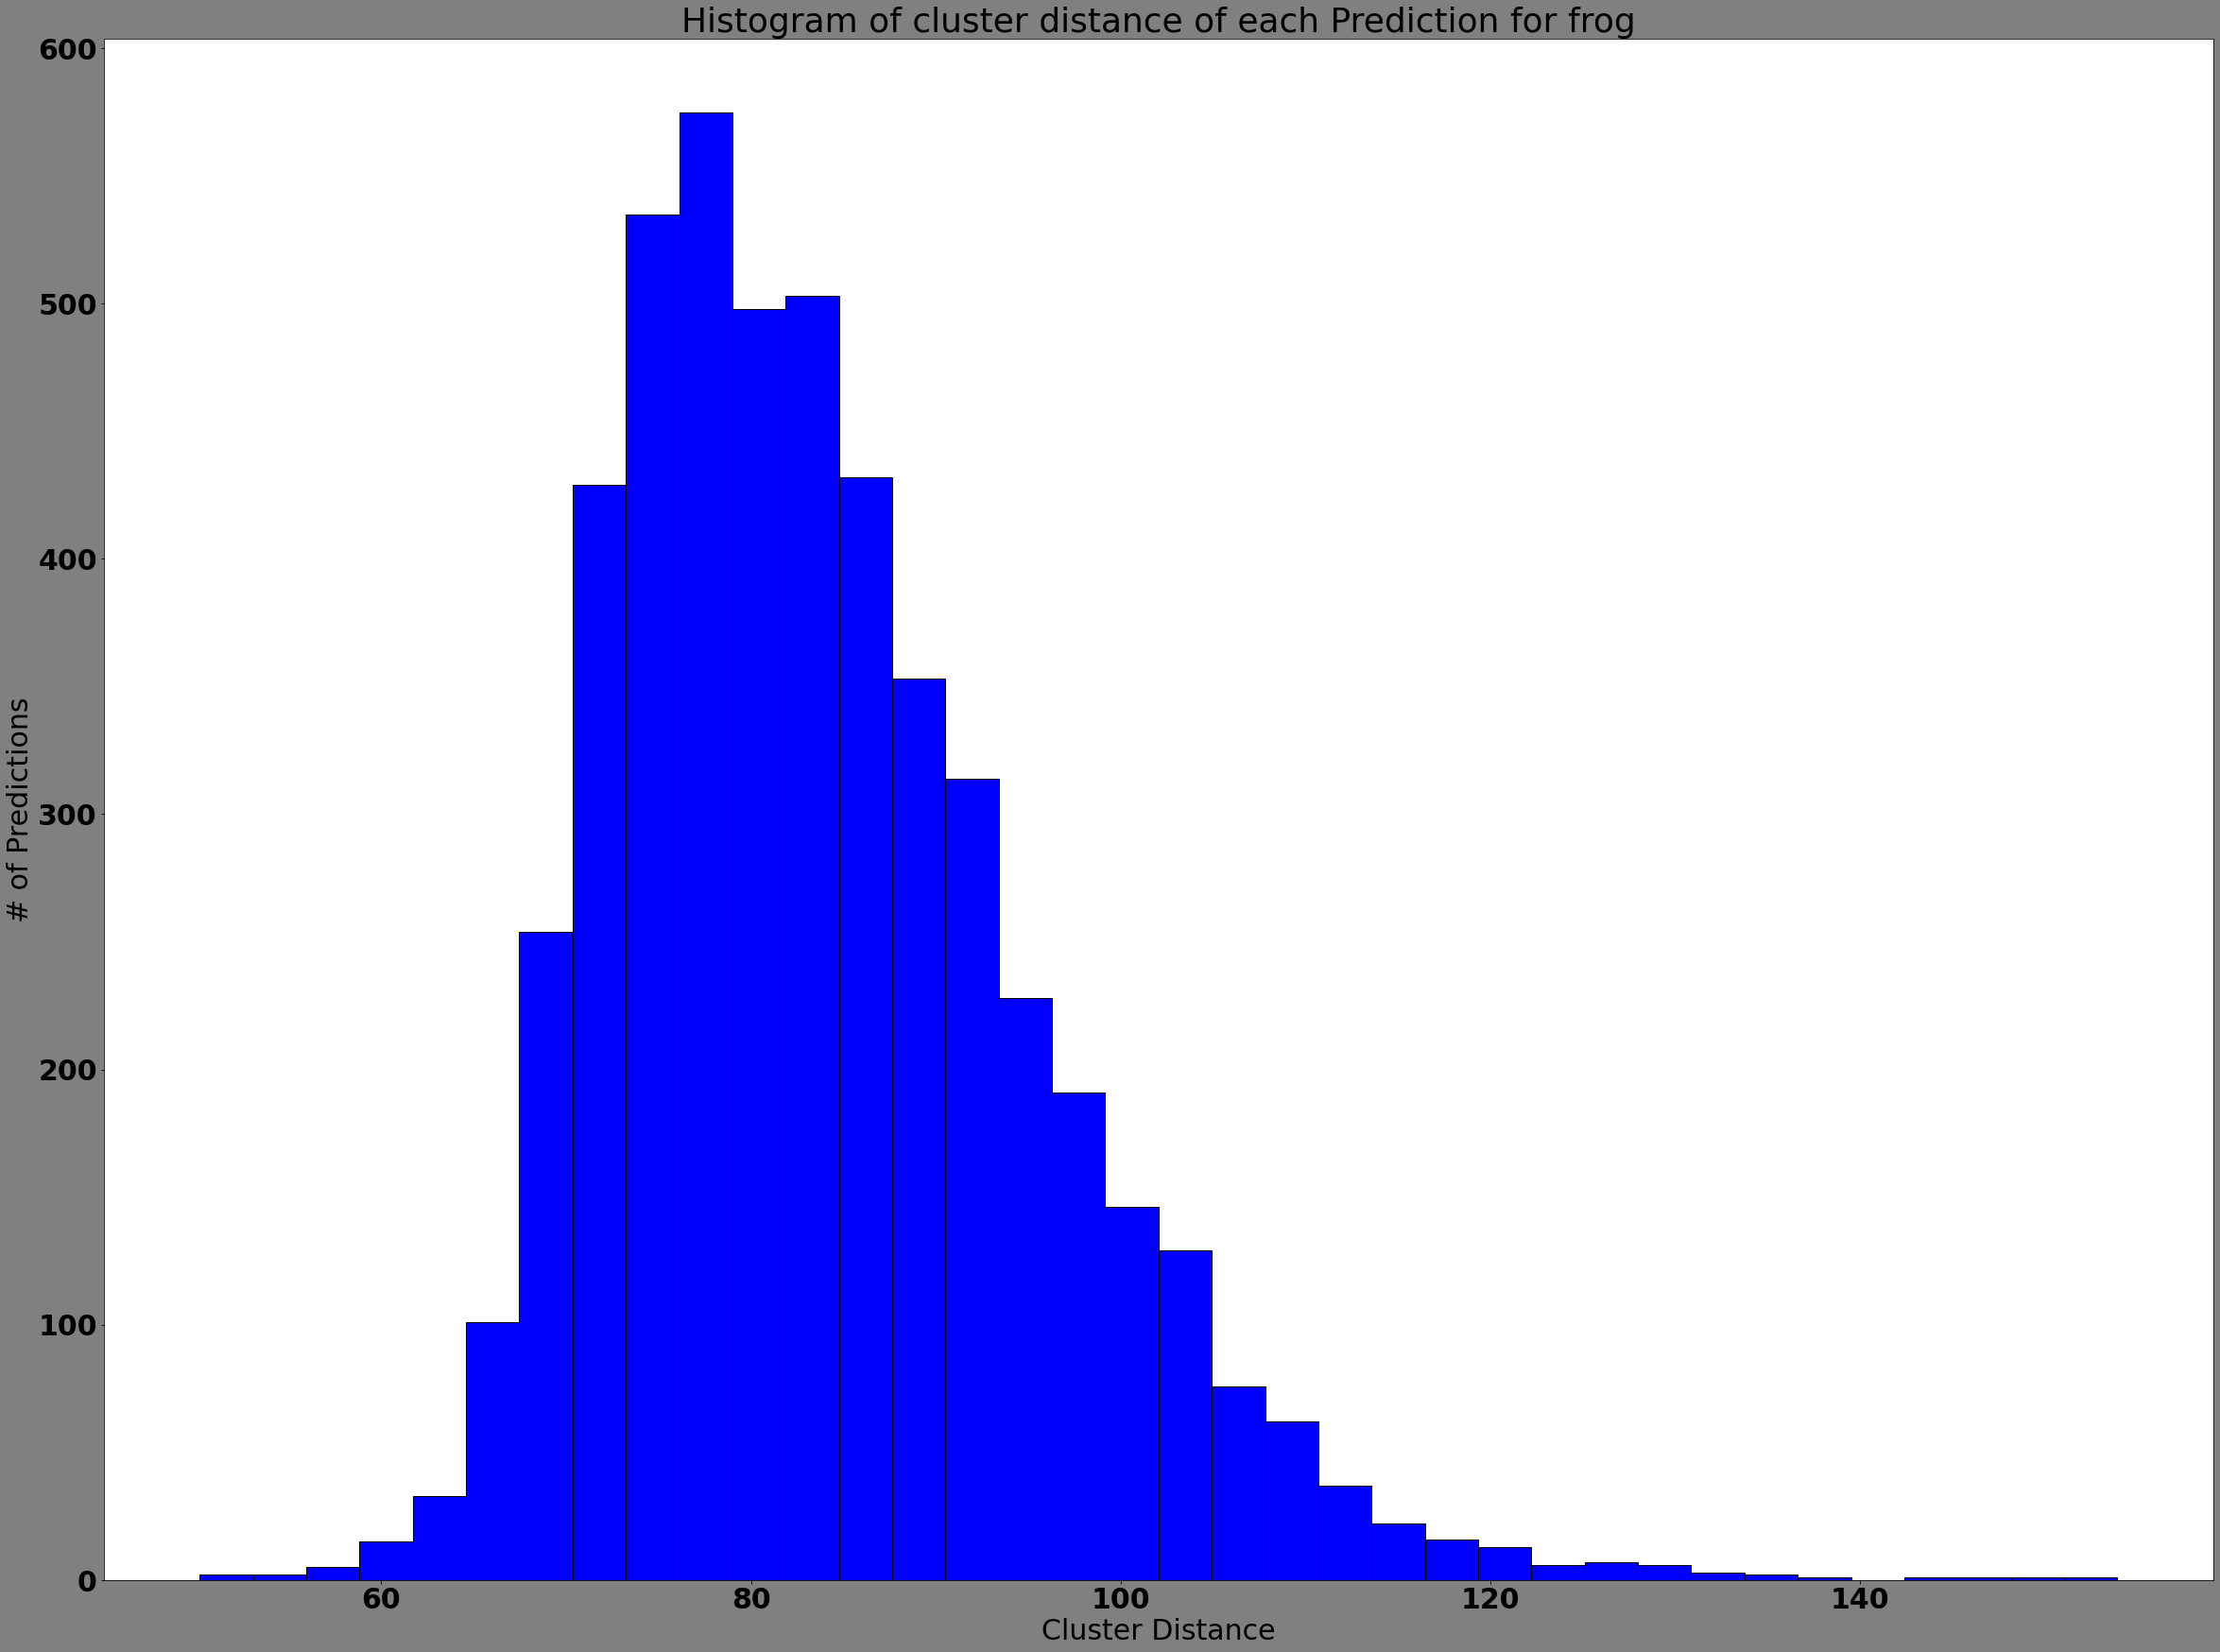

In [39]:
idx = 6

c = returnClassIndex(trainY,idx)
vals = k.transform(f[c])
plot_class_pdf(vals[:,idx], idx)

Mean: 90.1387710571289
Variance: 299.0379943847656
Standard Deviation: 17.292715072631836


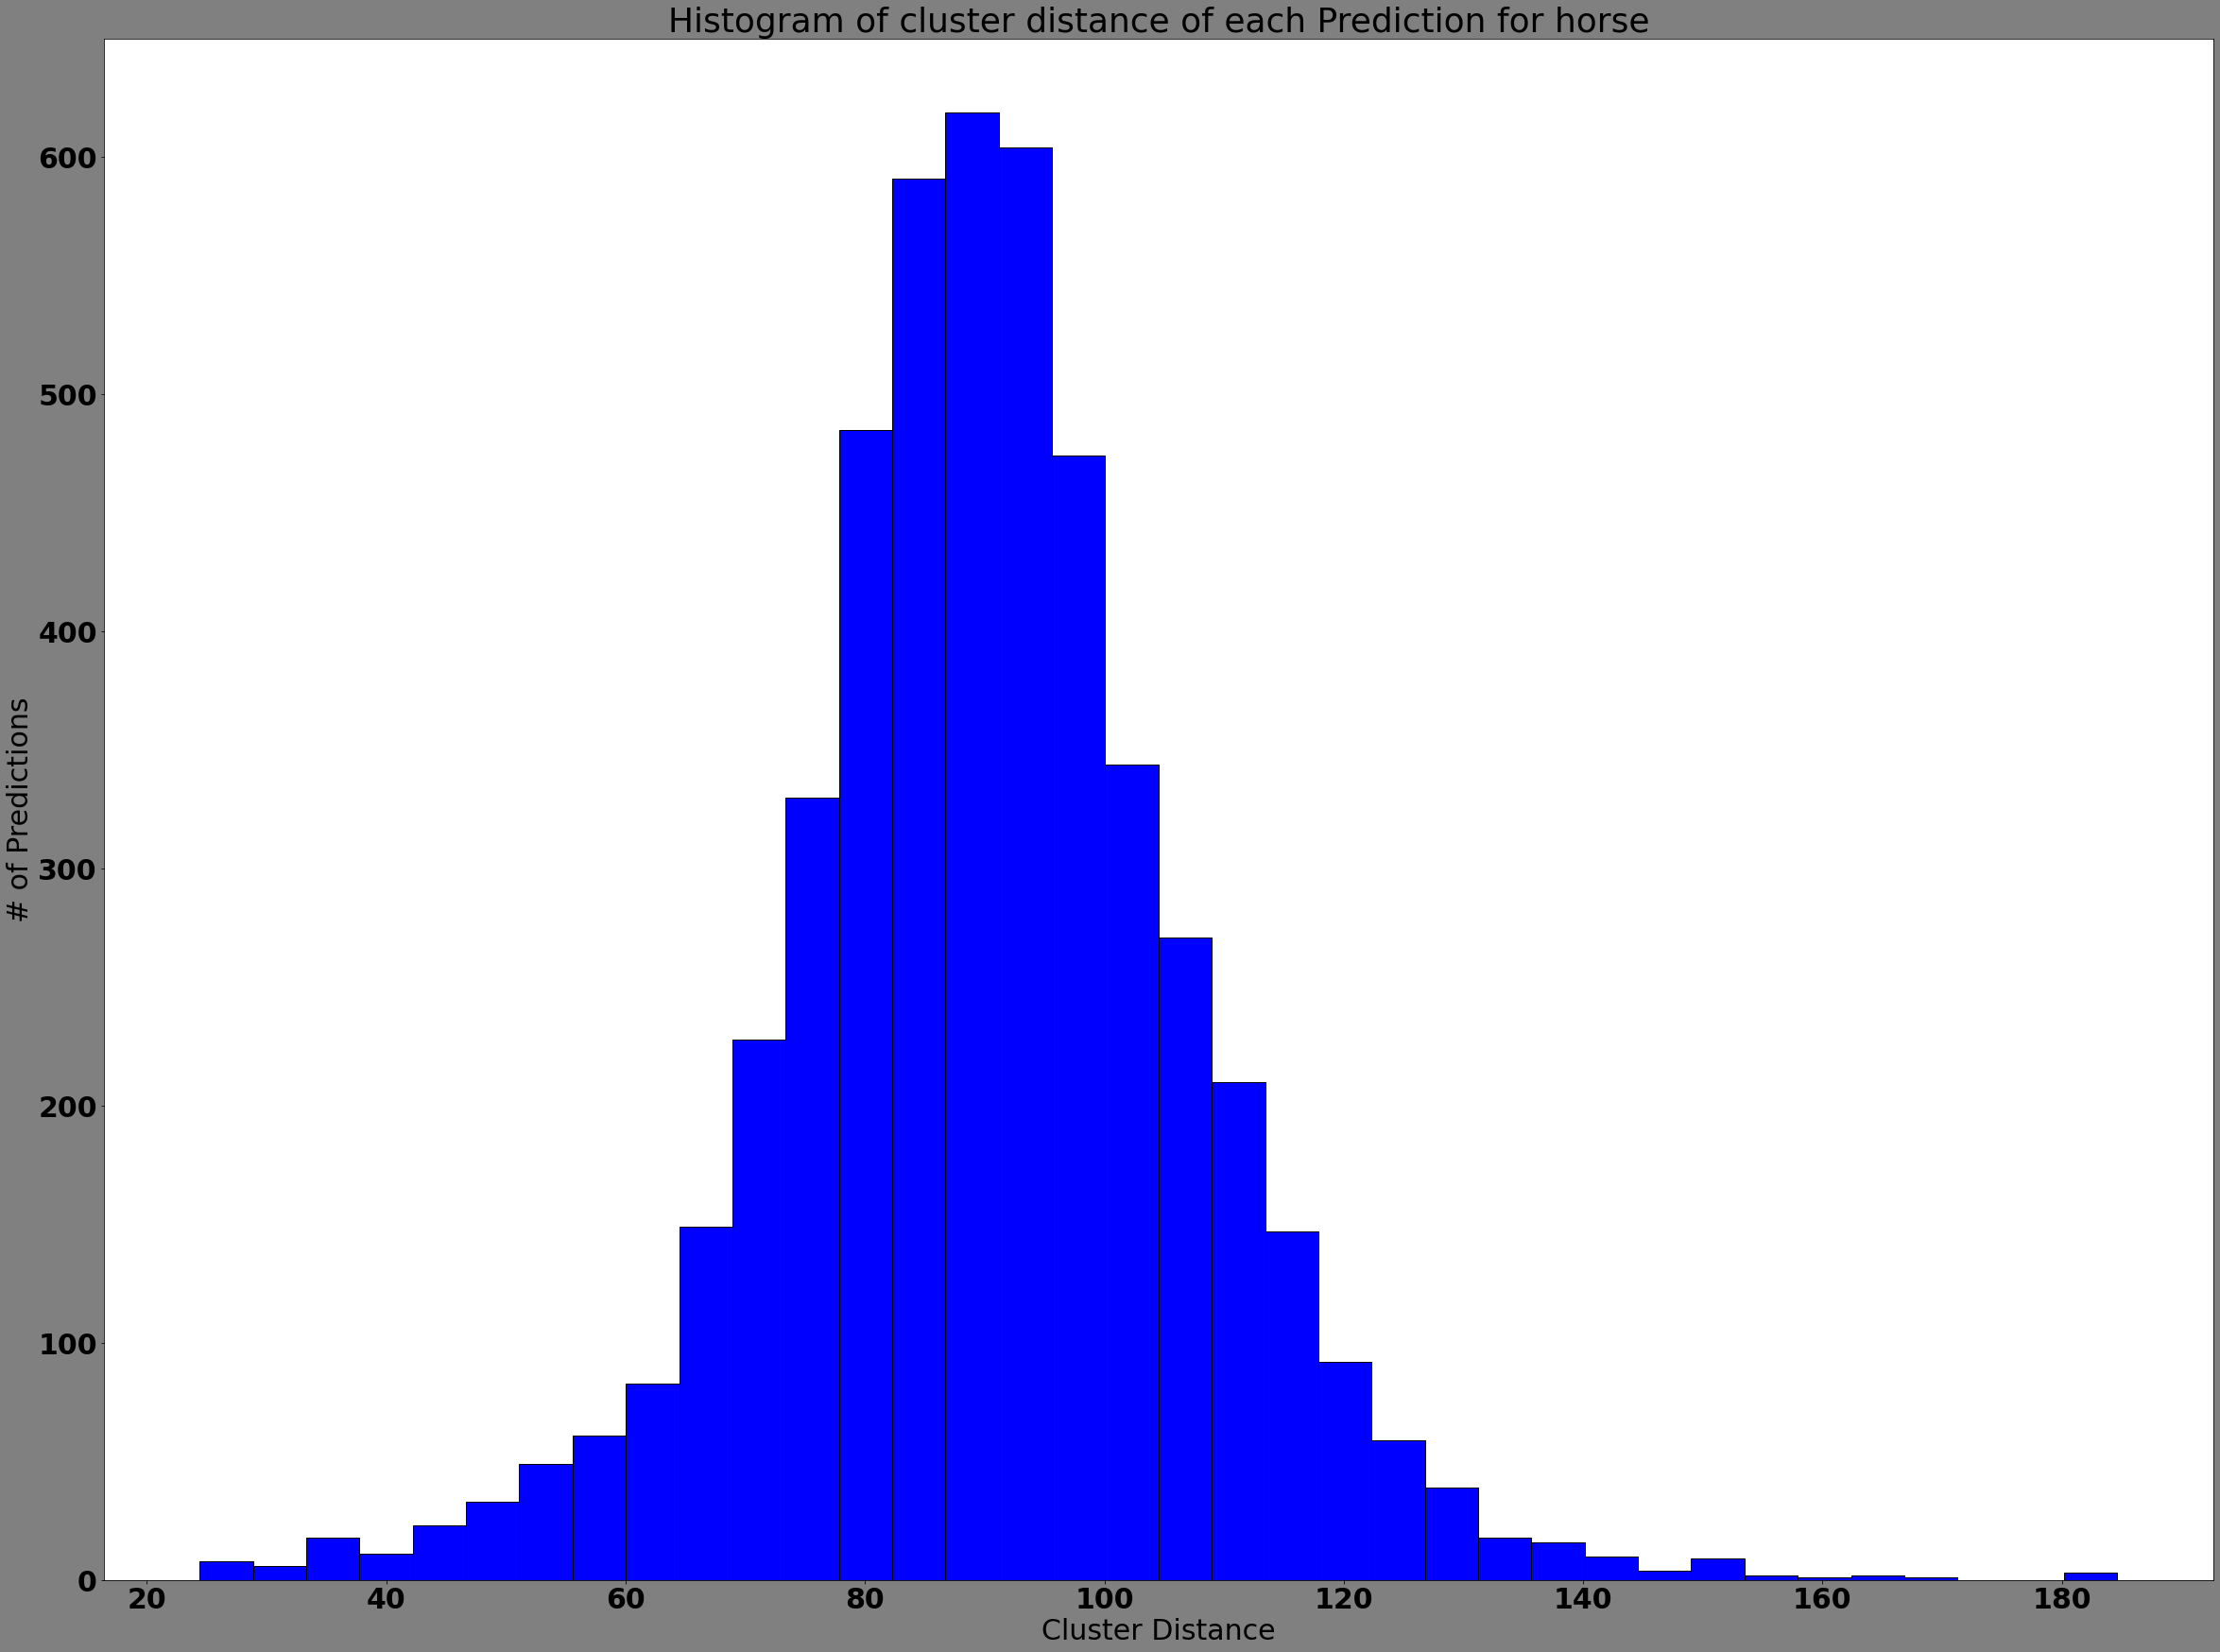

In [40]:
idx = 7

c = returnClassIndex(trainY,idx)
vals = k.transform(f[c])
plot_class_pdf(vals[:,idx], idx)

Mean: 66.54070281982422
Variance: 88.4107666015625
Standard Deviation: 9.402700424194336


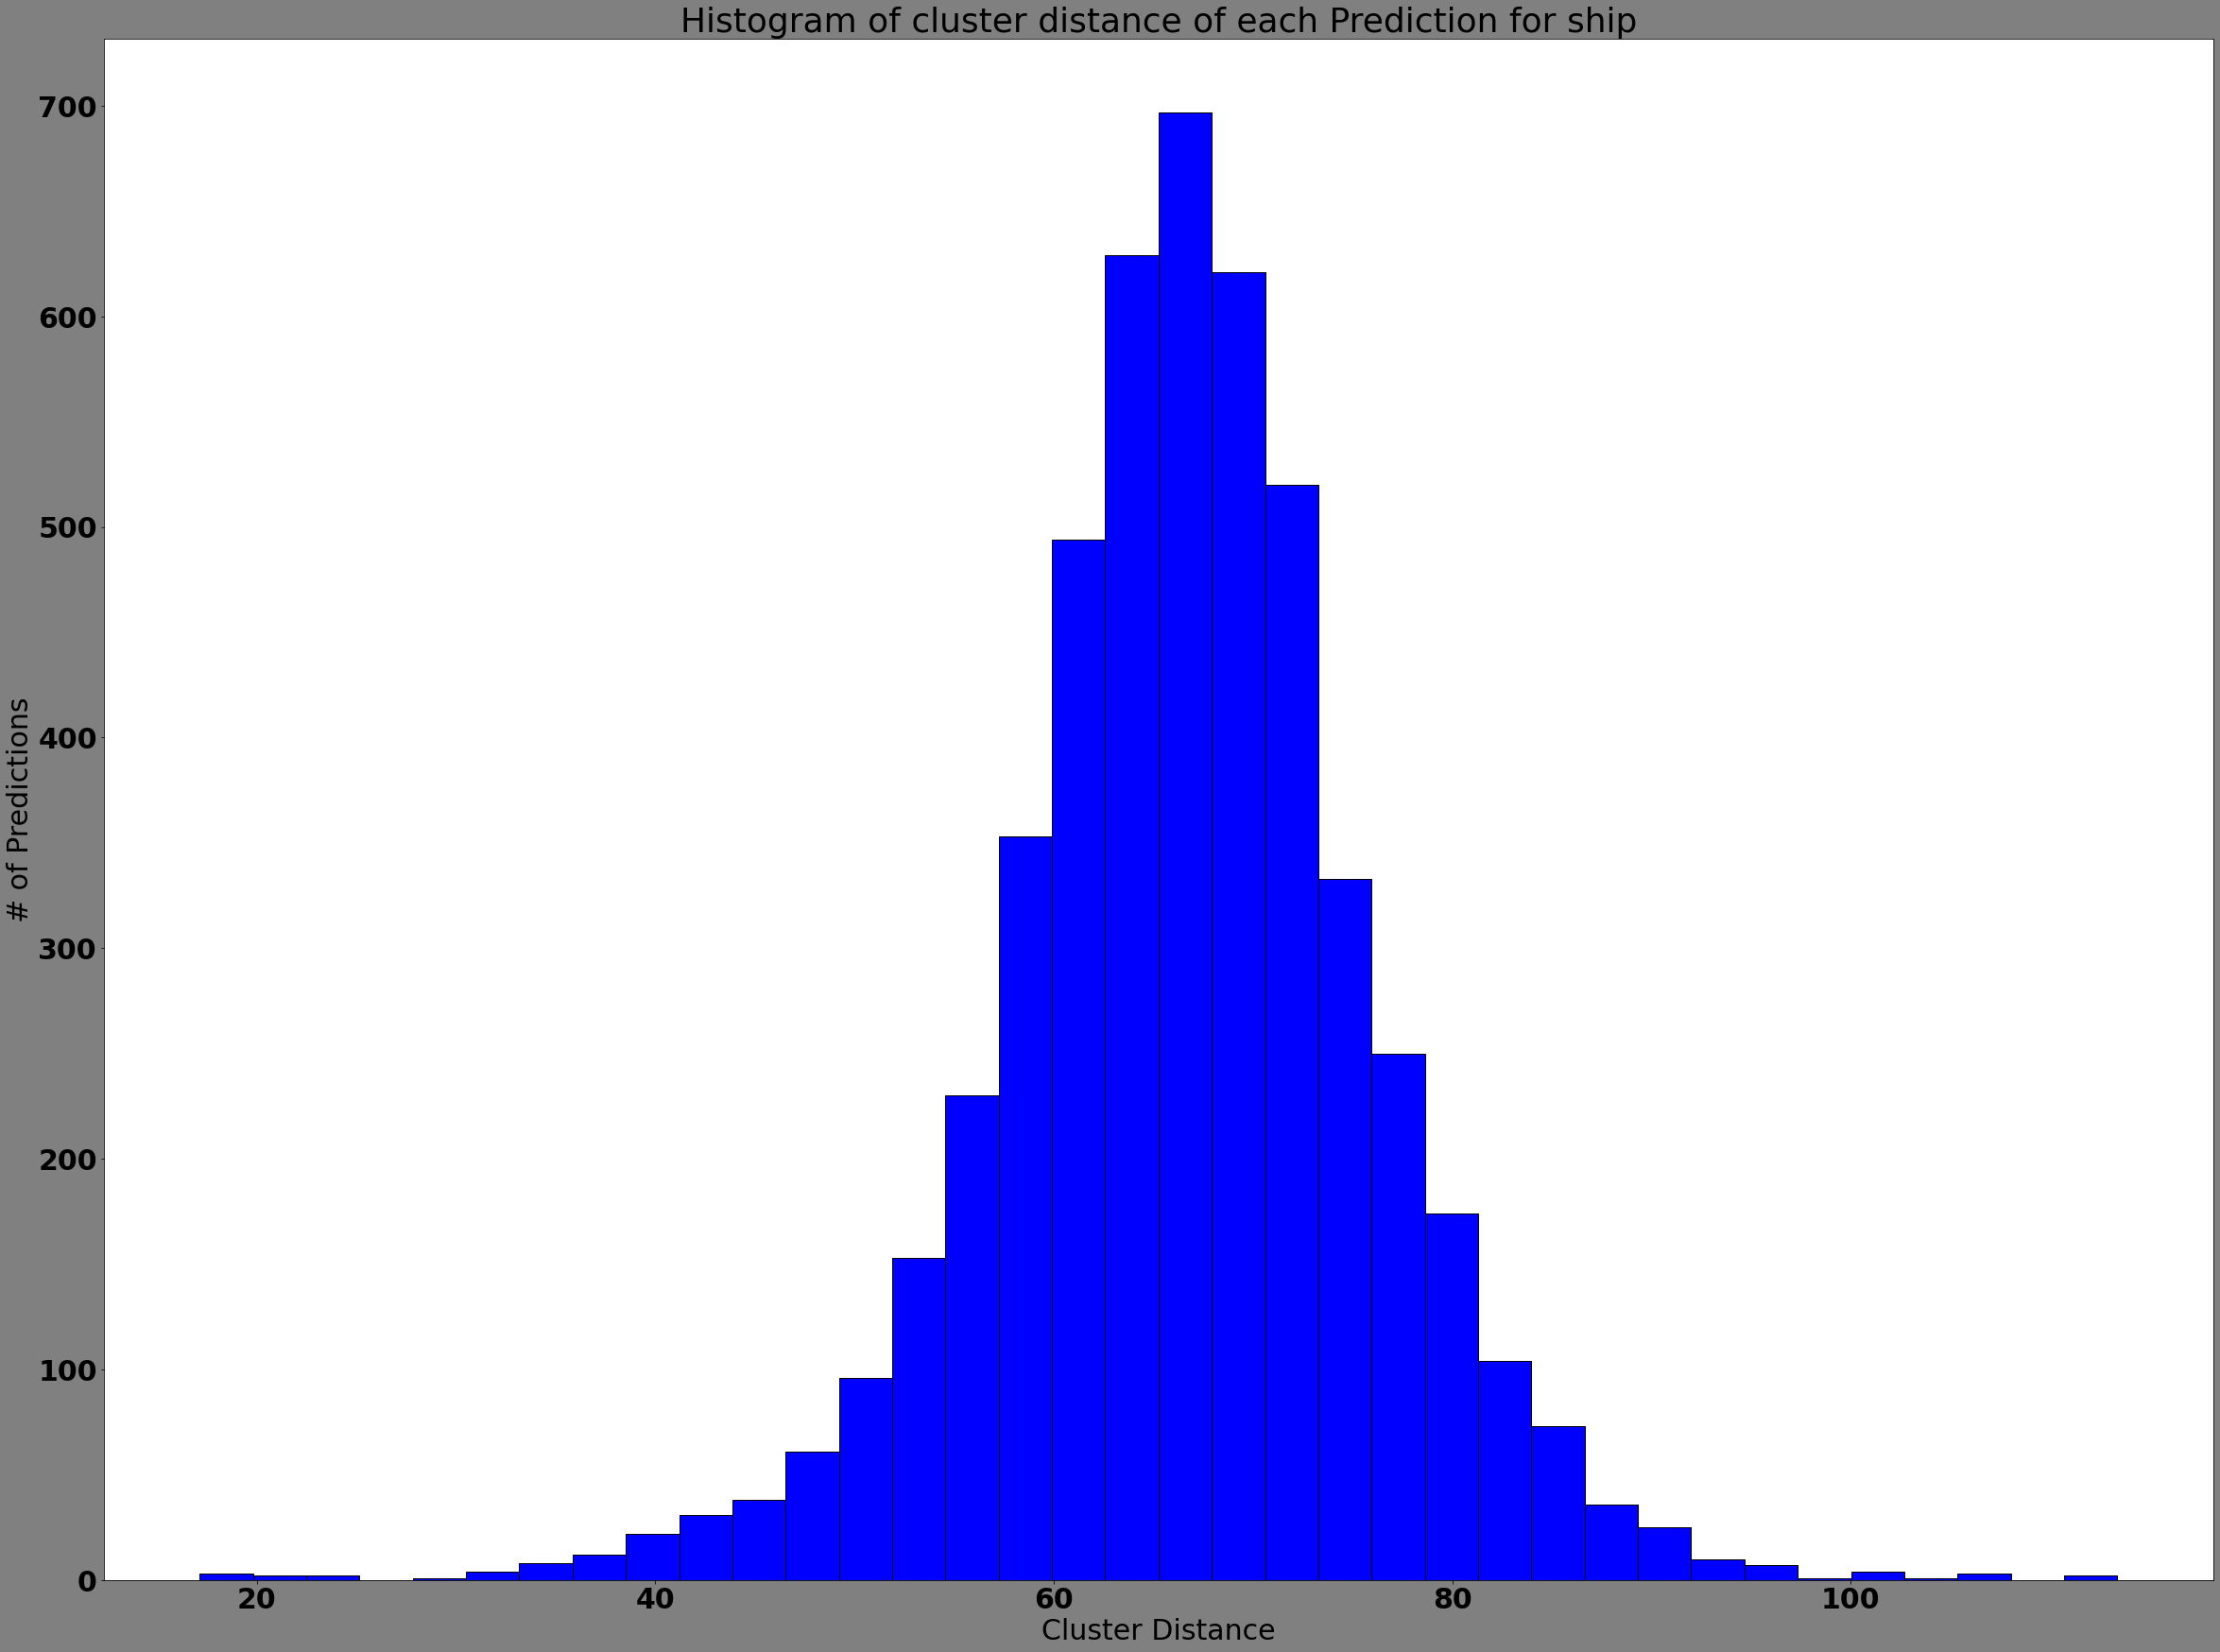

In [41]:
idx = 8

c = returnClassIndex(trainY,idx)
vals = k.transform(f[c])
plot_class_pdf(vals[:,idx], idx)

Mean: 93.62667846679688
Variance: 197.3831024169922
Standard Deviation: 14.049309730529785


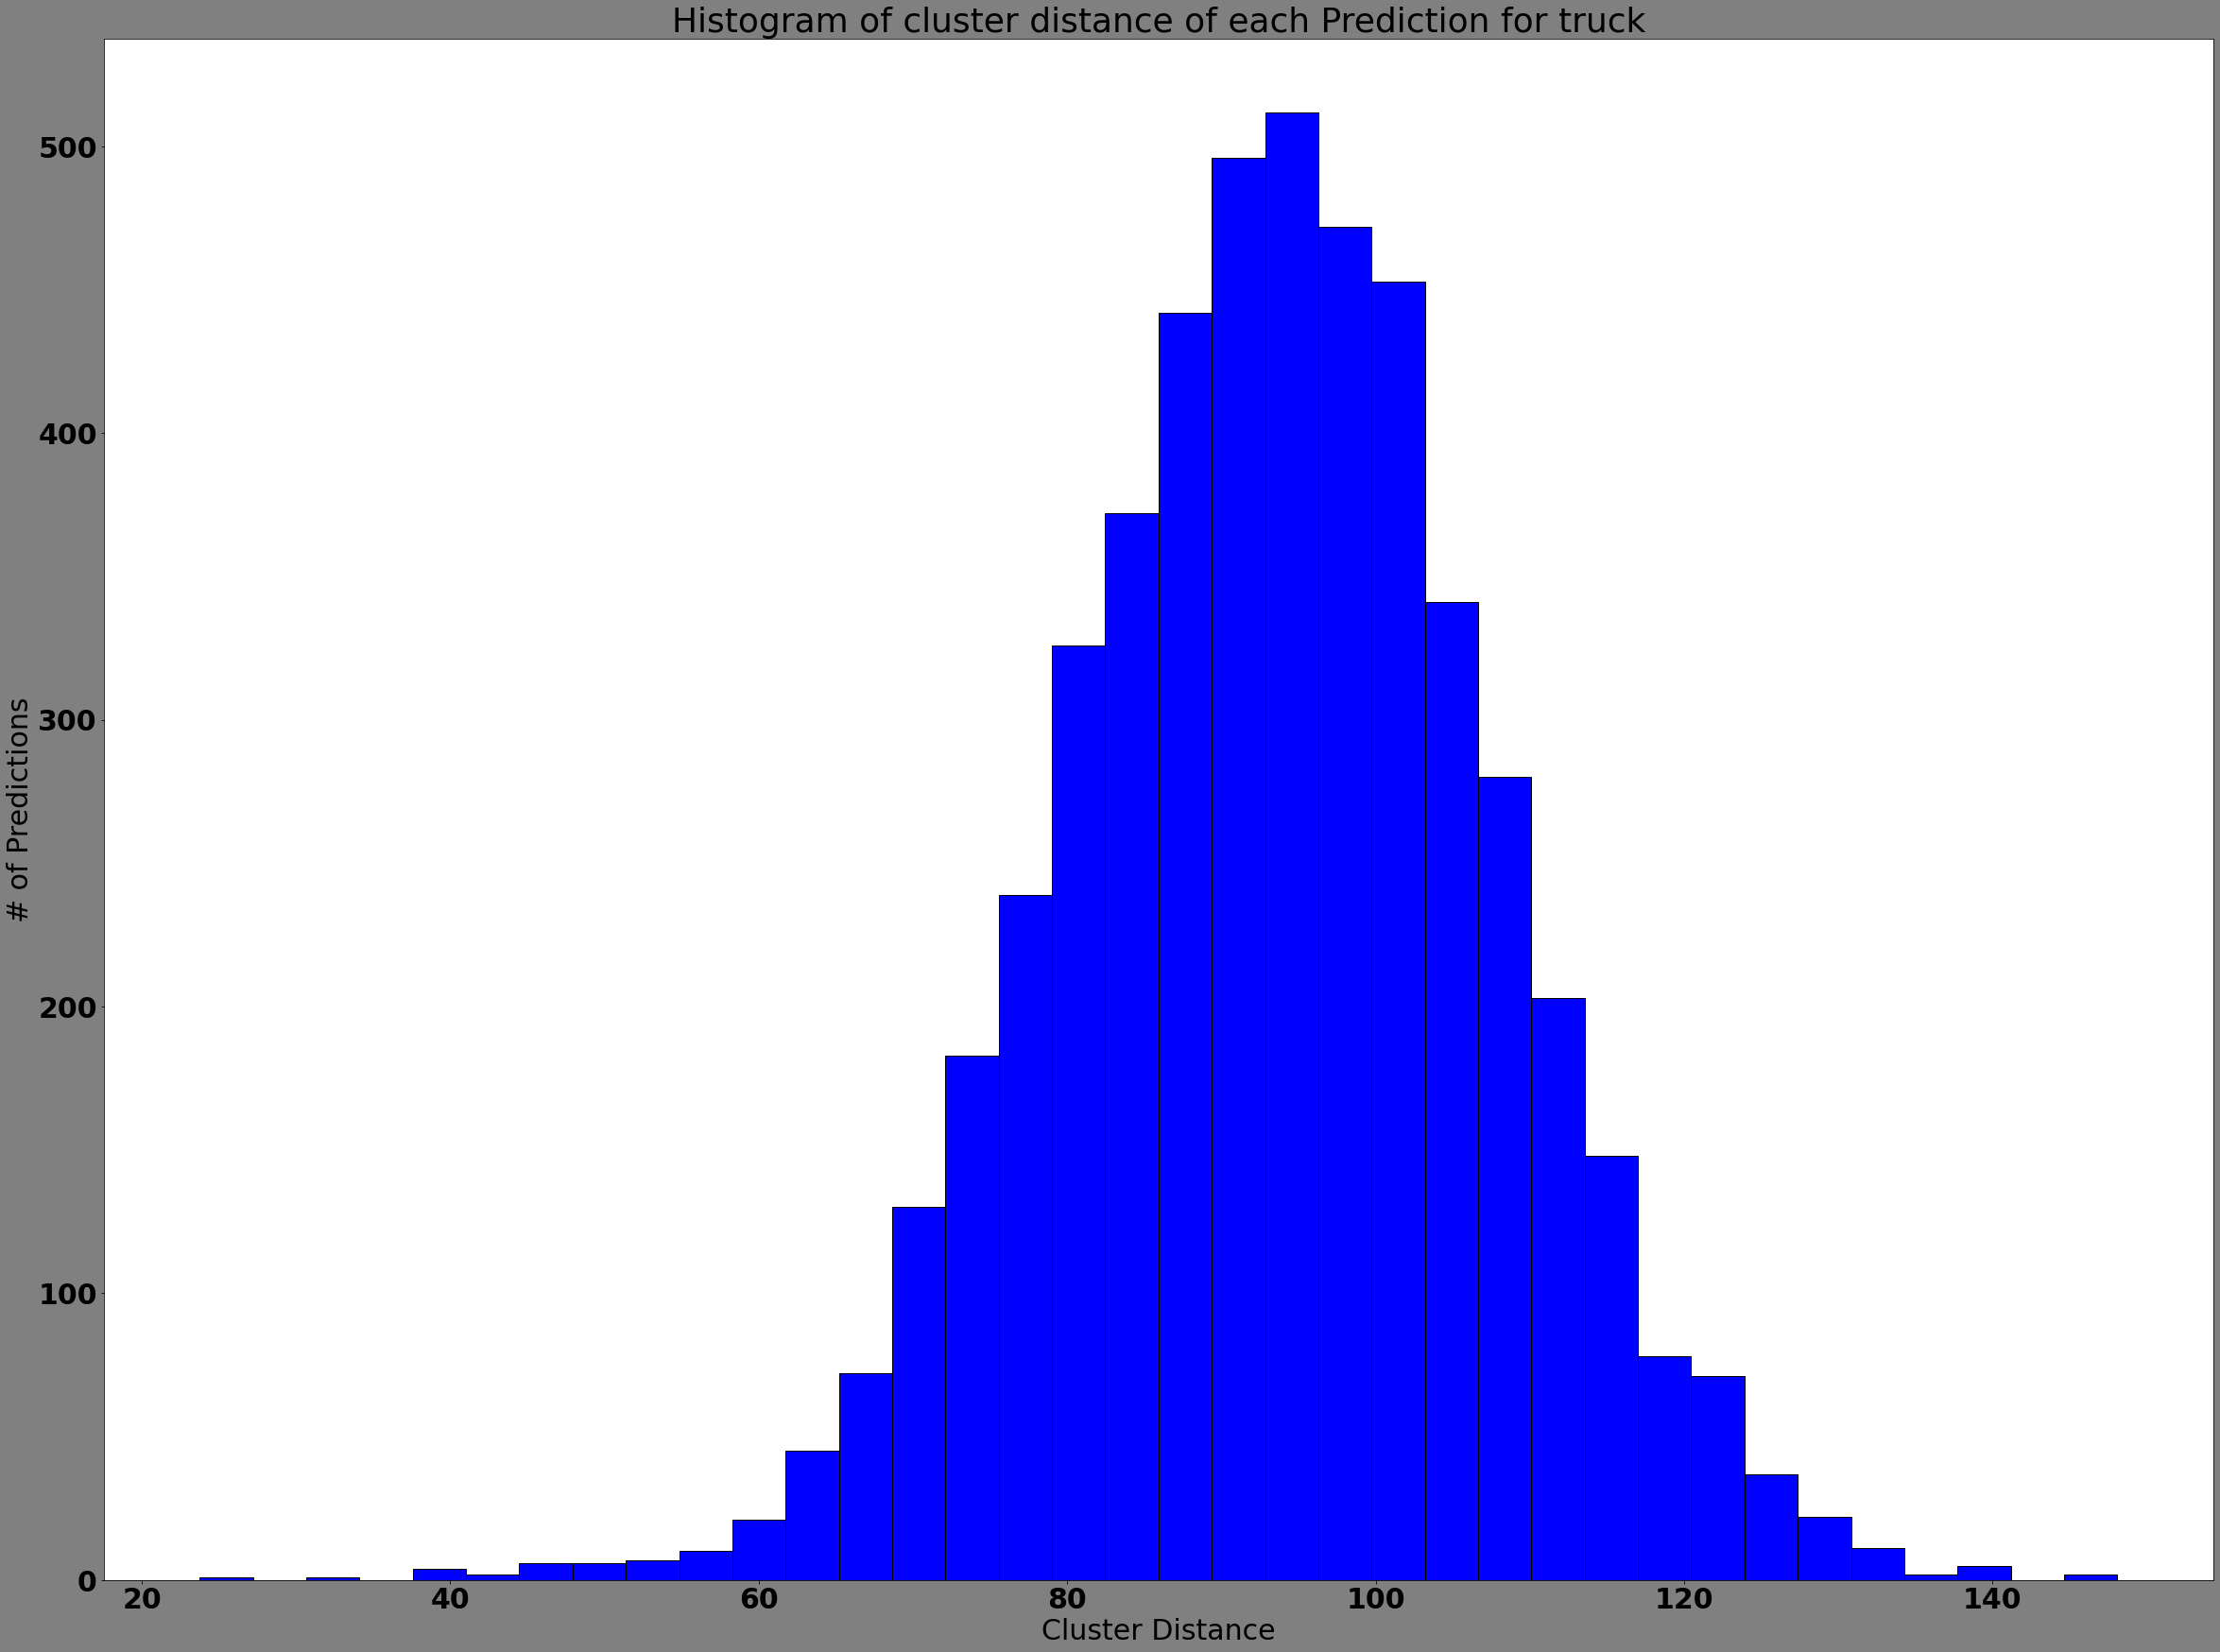

In [42]:
idx = 9

c = returnClassIndex(trainY,idx)
vals = k.transform(f[c])
plot_class_pdf(vals[:,idx], idx)